In [1]:
!apt-get install -y bedtools
!pip install genomepy
!pip install pyfaidx logomaker
!pip install networkx
!genomepy install hg38 -p UCSC -g hg38_genome.fa
!pip install ace_tools_open
!pip install node2vec
!pip install --upgrade biopython
!pip install pybedtools
!pip install gseapy
!pip install -q gprofiler-official
!apt-get -y install jellyfish samtools



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 563 kB of archives.
After this operation, 1,548 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 bedtools amd64 2.30.0+dfsg-2ubuntu0.1 [563 kB]
Fetched 563 kB in 1s (1,029 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Setting up bedtools (2.30.0+dfsg-2ubuntu0.1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 72.2 MB/s eta 0:00:00
   ━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 95.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 19.4 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.12.0-cp312-cp312-linux_x86_64.whl size=14340830 sha256=a0eae11d79e5fb0a31d3f7807f9ecbddca3073e78f807a6a9cff9521ba0d7953
  Stored in directory: /root/.cache/pip/wheels/ac/38/f2/960d79e44a92afc0d34a4727c856ce0149ac23c3dcda174356
Successfully built pybedtools
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 12.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libhts3 libhtscodecs2 libjellyfish-2.0-2
Suggested packages:
  cwltool
The following NEW packages will be installed:
  jellyfish libhts3 libhtscodecs2 libjellyfi

In [13]:
import os
import requests
import math
import seaborn as sns
from pathlib import Path
import gzip
import glob
import shutil
import random
from collections import defaultdict
from collections import Counter
from typing import Dict, List, Optional, Tuple
import re
from community import community_louvain
from sklearn.preprocessing import normalize
from Bio import SeqIO
from sklearn.metrics import adjusted_mutual_info_score
import networkx as nx
from community import community_louvain
from Bio.Seq import Seq
from pyfaidx import Fasta
import ace_tools_open as tools
import numpy as np
from Bio import motifs
from Bio.motifs import meme
import re
import time
import json
import math
import requests
from functools import lru_cache
import pandas as pd
from gprofiler import GProfiler
import pybedtools
import requests
from pybedtools import BedTool
import matplotlib.pyplot as plt
from itertools import combinations
import random
from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import gseapy as gp



In [2]:

COMP = str.maketrans("ACGT", "TGCA")
def rc(s: str) -> str:
    return s.translate(COMP)[::-1]
def canonical_kmer(k: str) -> str:
    r = rc(k)
    return k if k <= r else r


def search_encode_atac(tissue="K562", limit=20) -> List[Dict]:
    url = "https://www.encodeproject.org/search/"
    headers = {"Accept": "application/json", "User-Agent": "Mozilla/5.0"}
    params = {
        "type": "Experiment",
        "assay_title": "ATAC-seq",
        "biosample_ontology.term_name": tissue,
        "status": "released",
        "format": "json",
        "frame": "embedded",
        "limit": limit,
    }
    r = requests.get(url, headers=headers, params=params)
    r.raise_for_status()
    return r.json().get("@graph", [])








KEEP_TYPES    = {"IDR ranked peaks"}
KEEP_FORMATS  = {"bed","narrowPeak","broadPeak"}
KEEP_ASSEMBLY = {"GRCh38", "hg38"}

def download_idr_ranked_peaks(exp: Dict, save_dir="encode_peaks") -> List[str]:
    os.makedirs(save_dir, exist_ok=True)
    out = []
    for f in exp.get("files", []):
        ot = f.get("output_type", "")
        fmt = f.get("file_format", "")
        asm = f.get("assembly", "")
        if (ot in KEEP_TYPES) and (fmt in KEEP_FORMATS) and (asm in KEEP_ASSEMBLY):
            href = f.get("href")
            if not href:
                continue
            url = "https://www.encodeproject.org" + href
            fname = os.path.join(save_dir, os.path.basename(href))
            if not os.path.exists(fname):
                rr = requests.get(url, stream=True)
                rr.raise_for_status()
                with open(fname, "wb") as w:
                    for chunk in rr.iter_content(8192):
                        w.write(chunk)
            out.append(os.path.abspath(fname))
    return out


def encode_provenance_table(experiments_json: List[Dict], used_absolute_paths: List[str]) -> pd.DataFrame:
    used_set = set(os.path.abspath(p) for p in used_absolute_paths)
    rows = []
    for exp in experiments_json:
        exp_acc  = exp.get("accession")
        biosample = (exp.get("biosample_ontology") or {}).get("term_name", "")
        organism  = (exp.get("organism") or {}).get("scientific_name", "")
        lab       = (exp.get("lab") or {}).get("title", "")
        award     = (exp.get("award") or {}).get("rfa", "")
        exp_url   = f"https://www.encodeproject.org/experiments/{exp_acc}/" if exp_acc else ""
        for f in exp.get("files", []):
            if f.get("file_format") not in KEEP_FORMATS:
                continue
            if f.get("output_type") not in KEEP_TYPES:
                continue
            if f.get("assembly") not in KEEP_ASSEMBLY:
                continue
            href = f.get("href","")
            file_url = f"https://www.encodeproject.org{href}" if href else ""
            local_abs = os.path.abspath(os.path.join("encode_peaks", os.path.basename(href))) if href else ""
            rows.append({
                "experiment": exp_acc,
                "experiment_url": exp_url,
                "biosample": biosample,
                "organism": organism,
                "lab": lab,
                "award": award,
                "file_accession": f.get("accession"),
                "file_format": f.get("file_format"),
                "output_type": f.get("output_type"),
                "assembly_file": f.get("assembly", ""),
                "file_status": f.get("status"),
                "md5sum": f.get("md5sum"),
                "file_size": f.get("file_size"),
                "file_url": file_url,
                "used_in_this_run": (local_abs in used_set)
            })
    return pd.DataFrame(rows)

def load_and_subset_peaks_with_names(files: List[str], n=150000, out_bed="atac_peaks_named.bed") -> str:
    import gzip
    import pandas as pd
    dfs = []
    for path in files:
        opener = gzip.open if path.endswith(".gz") else open
        with opener(path, "rt") as f:
            df = pd.read_csv(f, sep="\t", header=None, usecols=[0,1,2], names=["chrom","start","end"])
            dfs.append(df)
    if not dfs:
        raise RuntimeError("No peak files passed to loader.")
    all_peaks = pd.concat(dfs, ignore_index=True)
    all_peaks = all_peaks[all_peaks["chrom"].str.match(r"^chr([0-9]{1,2}|X|Y)$")].copy()
    all_peaks.drop_duplicates(["chrom","start","end"], inplace=True)

    if n and len(all_peaks) > n:
        all_peaks = all_peaks.sample(n=n, random_state=42).sort_values(["chrom","start","end"])
    all_peaks = all_peaks.reset_index(drop=True)
    all_peaks["name"] = [f"peak_{i}" for i in range(len(all_peaks))]
    all_peaks[["chrom","start","end","name"]].to_csv(out_bed, sep="\t", header=False, index=False)
    print(f"✓ Built {out_bed} with {len(all_peaks):,} peaks from {len(files)} IDR-ranked files")
    return out_bed




experiments = search_encode_atac("K562", limit=20)
downloaded_abs = []
for exp in experiments:
    downloaded_abs.extend(download_idr_ranked_peaks(exp, save_dir="encode_peaks"))

prov = encode_provenance_table(experiments, downloaded_abs)
prov_path = "encode_atac_provenance.tsv"
prov.to_csv(prov_path, sep="\t", index=False)
print(f"✓ Wrote {prov_path} (n={len(prov)})")

peak_bed = load_and_subset_peaks_with_names(downloaded_abs, n=150_000, out_bed="atac_peaks_named.bed")




✓ Wrote encode_atac_provenance.tsv (n=80)
✓ Built atac_peaks_named.bed with 150,000 peaks from 80 IDR-ranked files


In [3]:
%%bash
set -euo pipefail

gtf_source_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz"

wget -N "$gtf_source_url"

gunzip -c gencode.v43.annotation.gtf.gz > gencode.v43.annotation.gtf

ln -sf gencode.v43.annotation.gtf gencode.gtf



--2025-10-23 00:14:50--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49661267 (47M) [application/x-gzip]
Saving to: ‘gencode.v43.annotation.gtf.gz’

     0K .......... .......... .......... .......... ..........  0%  194K 4m9s
    50K .......... .......... .......... .......... ..........  0%  154M 2m5s
   100K .......... .......... .......... .......... ..........  0%  389K 2m4s
   150K .......... .......... .......... .......... ..........  0%  229M 93s
   200K .......... .......... .......... .......... ..........  0% 1.44M 81s
   250K .......... .......... .......... .......... ..........  0%  527K 83s
   300K .......... .......... .......... .......... ..........  0%  256M 71s
   350K .......... .......... .......... .......... .......... 

In [4]:
%%bash
set -euo pipefail

BASE="hg38_genome.fa"
FA="$BASE/hg38/hg38.fa"
PEAKS="atac_peaks_named.bed"


[ -f "$FA" ] || { echo "FASTA not found: $FA"; exit 1; }
[ -s "$PEAKS" ] || { echo "Peaks BED missing: $PEAKS"; exit 2; }


samtools faidx "$FA"
cut -f1,2 "$FA.fai" > hg38.genome


bedtools shuffle -i "$PEAKS" -g hg38.genome -chrom -excl "$PEAKS" -noOverlapping -seed 42 > peaks_bg.bed


bedtools getfasta -fi "$FA" -bed "$PEAKS"     -fo atac_peak_seqs.fa -name
bedtools getfasta -fi "$FA" -bed peaks_bg.bed -fo atac_peak_bg.fa   -name


jellyfish count -m 6 -C -s 10M -t 8 -o fg_k6.jf atac_peak_seqs.fa
jellyfish dump  -c            fg_k6.jf > fg_k6.tsv

jellyfish count -m 6 -C -s 10M -t 8 -o bg_k6.jf atac_peak_bg.fa
jellyfish dump  -c            bg_k6.jf > bg_k6.tsv


In [5]:


fg = pd.read_csv("fg_k6.tsv", sep=r"\s+", header=None, names=["kmer","fg"], engine="python")
bg = pd.read_csv("bg_k6.tsv", sep=r"\s+", header=None, names=["kmer","bg"], engine="python")


fg = fg[fg["kmer"].str.fullmatch(r"[ACGT]{6}")].copy()
bg = bg[bg["kmer"].str.fullmatch(r"[ACGT]{6}")].copy()


km = fg.merge(bg, on="kmer", how="outer").fillna(0)
km["fg"] = km["fg"].astype(int)
km["bg"] = km["bg"].astype(int)
km["log2_enrichment"] = np.log2((km["fg"] + 1) / (km["bg"] + 1))
km.sort_values("log2_enrichment", ascending=False, inplace=True)


all_kmers = set(km["kmer"].values)


print(km.head(3))
print("Unique kmers:", len(all_kmers))


        kmer     fg    bg  log2_enrichment
1325  CGCGCG  24537   634         5.272117
1317  CGCCGC  81901  2262         5.177590
1327  CGCGGC  59264  1786         5.051569
Unique kmers: 2080


In [6]:
OLFA_TASTE_RX = re.compile(
    r"""^(
            OR\d+[A-Z]*\d*      # OR1, OR2A1, OR10G7, OR52E4, ...
          | OR[A-Z]{1,2}\d+     # ORA1, ORAA2  (rare formats)
          | TAS1R[123]          # TAS1R1, TAS1R2, TAS1R3
          | TAS2R\d+            # TAS2R38, TAS2R13, ...
        )$""",
    re.IGNORECASE | re.VERBOSE
)

def is_low_specificity_symbol(sym: str) -> bool:
    s = (sym or "").strip().upper()
    return bool(OLFA_TASTE_RX.match(s))



gtf_cols = ["chrom","source","feature","start","end","score","strand","frame","attribute"]
gtf = pd.read_csv("gencode.gtf", sep="\t", comment="#", header=None, names=gtf_cols, low_memory=False)
gtf["gene_type"] = gtf["attribute"].str.extract('gene_type "([^"]+)"')
genes = gtf[(gtf["feature"]=="gene") & (gtf["gene_type"]=="protein_coding")].copy()


chrom_ok = genes["chrom"].str.match(r"^chr([0-9]{1,2}|X|Y)$")
genes = genes[chrom_ok].copy()
genes["gene_name"] = genes["attribute"].str.extract('gene_name "([^"]+)"')
genes["gene_name_u"] = genes["gene_name"].str.upper()
bad = genes["gene_name_u"].map(is_low_specificity_symbol)

print(f"[blacklist] Removing {bad.sum():,} genes (olfactory/taste), "
      f"keeping {(~bad).sum():,} of {len(genes):,}.")

genes = genes[~bad].copy()
genes["tss"] = genes.apply(lambda r: r["start"] - 1 if r["strand"] == "+" else r["end"] - 1, axis=1)
bed = genes[["chrom", "tss", "gene_name"]].copy()
bed["start"] = bed["tss"]
bed["end"] = bed["tss"] + 1
bed = bed[["chrom", "start", "end", "gene_name"]].sort_values(by=["chrom", "start"])
bed.to_csv("gencode_tss.bed", sep="\t", header=False, index=False)
print("✅ Saved gencode_tss.bed")

fasta = Fasta("atac_peak_seqs.fa")
seqs = [str(record).upper() for record in fasta.values()]

[blacklist] Removing 438 genes (olfactory/taste), keeping 19,591 of 20,029.
✅ Saved gencode_tss.bed


In [29]:
bed.head()


,chrom,start,end,gene_name
982,chr1,923922,923923,SAMD11
1287,chr1,959308,959309,NOC2L
1369,chr1,960583,960584,KLHL17
1420,chr1,966481,966482,PLEKHN1
1545,chr1,982116,982117,PERM1


In [8]:

with open("JASPAR2024_CORE_vertebrates.pfm") as handle:
    jaspar_motifs = list(motifs.parse(handle, "jaspar"))


def motif_ic(m, pseudocount=0.1, background=None):


    counts = np.vstack([np.asarray(m.counts[b], dtype=float) for b in "ACGT"])
    if background is None:
        background = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)[:, None]
    counts += pseudocount
    p = counts / counts.sum(axis=0, keepdims=True)
    ic_cols = (p * (np.log2(p + 1e-12) - np.log2(background))).sum(axis=0)
    return float(ic_cols.sum())


tf_to_motifs = defaultdict(list)
for m in jaspar_motifs:
    tf_to_motifs[m.name].append(m)


tf_to_best_pwm = {}
for tf, mlist in tf_to_motifs.items():
    best_motif = max(mlist, key=motif_ic)
    tf_to_best_pwm[tf] = best_motif.pssm


motif_pwms = list(tf_to_best_pwm.items())






def max_kmer_score_against_pssm(kmer, pssm):
    L = len(pssm['A'])
    best = -np.inf
    for probe in (kmer, rc(kmer)):
        if len(probe) > L:
            continue
        for i in range(L - len(probe) + 1):
            s = 0.0
            for j, base in enumerate(probe):
                s += pssm[base][i + j]
            if s > best:
                best = s
    return best

results = []
for kmer in all_kmers:
    for name, pwm in motif_pwms:
        try:
            score = max_kmer_score_against_pssm(kmer, pwm)
            results.append((kmer, name, score))
        except:
            continue

df_scores = pd.DataFrame(results, columns=["kmer", "TF_motif", "score"])


K = 6
kmer_domain = list(set(km["kmer"].values))


bg_counts = bg.set_index("kmer")["bg"].astype(float)
w = pd.Series(index=kmer_domain, data=0.0)
w.loc[bg_counts.index.intersection(w.index)] = bg_counts.loc[bg_counts.index.intersection(w.index)].values
w_sum = float(w.sum())
if w_sum <= 0:

    w[:] = 1.0 / len(w)
else:
    w /= w_sum
def motif_bg_stats(pwm, kmers, weights):
    scores = np.empty(len(kmers), dtype=float)
    for i, kmer in enumerate(kmers):
        scores[i] = max_kmer_score_against_pssm(kmer, pwm)
    finite = np.isfinite(scores)
    if finite.sum() == 0:
        return 0.0, 1.0
    wf_all = weights.reindex(kmers).fillna(0.0).to_numpy()
    wf = wf_all[finite]
    sf = scores[finite]
    wf = wf / (wf.sum() + 1e-12)
    mu = float((sf * wf).sum())
    mu2 = float(((sf**2) * wf).sum())
    sigma = float(np.sqrt(max(mu2 - mu**2, 0.0)))

    if sigma < 1e-9:
        sigma = 1.0
    return mu, sigma



bg_by_motif = {}
for name, pwm in motif_pwms:
    mu, sigma = motif_bg_stats(pwm, kmer_domain, w)
    bg_by_motif[name] = (mu, sigma)


df_scores["z"] = df_scores.apply(
    lambda r: (r["score"] - bg_by_motif[r["TF_motif"]][0]) / (bg_by_motif[r["TF_motif"]][1] + 1e-12),
    axis=1
)




peaks = BedTool("atac_peaks_named.bed").sort()
tss = BedTool("gencode_tss.bed").sort()

mapped = peaks.closest(tss, d=True)
mapped_df = mapped.to_dataframe(names=[
    "peak_chrom", "peak_start", "peak_end", "peak_name",
    "gene_chrom", "gene_start", "gene_end", "gene_name", "distance"
])
MAX_DIST = 50_000
mapped_df = mapped_df[mapped_df["distance"] <= MAX_DIST].copy()
mapped_df["peak_id"] = mapped_df["peak_chrom"] + ":" + mapped_df["peak_start"].astype(str) + "-" + mapped_df["peak_end"].astype(str)

HALF_LIFE = 10_000
TAU = HALF_LIFE / np.log(2.0)


mapped_df["w_dist"] = np.exp(-mapped_df["distance"] / TAU).astype(np.float32)


fasta = Fasta("atac_peak_seqs.fa")
peak_seqs_clean = {k.split("::")[0]: str(v).upper() for k, v in fasta.items()}


mapped_df = mapped_df[mapped_df["peak_name"].isin(peak_seqs_clean.keys())].copy()
mapped_df["sequence"] = mapped_df["peak_name"].map(peak_seqs_clean)




TFs   = pd.Index(sorted(df_scores["TF_motif"].unique()))
tf2i  = {tf:i for i, tf in enumerate(TFs)}

Z_MIN_PAIR       = 2.5
TOP_TF_PER_KMER  = 32

df_k2tf = (df_scores
           .assign(kmer=lambda d: d["kmer"].map(canonical_kmer))
           .query("z >= @Z_MIN_PAIR")
           .sort_values(["kmer","z"], ascending=[True, False])
           .groupby("kmer", as_index=False)
           .head(TOP_TF_PER_KMER))


k2tf = {}
for ck, g in df_k2tf.groupby("kmer"):
    idx = g["TF_motif"].map(tf2i).to_numpy(dtype=np.int32)
    w   = g["z"].to_numpy(dtype=np.float32)
    k2tf[ck] = (idx, w)


from collections import Counter
import numpy as np

K = 6
TOP_TF_PER_PEAK = 20
S_MIN = 0.0

edges = []
for _, row in mapped_df.iterrows():
    seq  = row["sequence"].upper()
    gene = row["gene_name"]

    w_d  = float(row.get("w_dist", 1.0))

    counts = Counter(canonical_kmer(seq[i:i+K]) for i in range(len(seq)-K+1))


    scores = np.zeros(len(TFs), dtype=np.float32)
    for ck, c in counts.items():
        hit = k2tf.get(ck)
        if hit is None:
            continue
        idx, w = hit
        scores[idx] += c * w

    scores *= w_d

    if TOP_TF_PER_PEAK and scores.any():
        top = np.argpartition(scores, -TOP_TF_PER_PEAK)[-TOP_TF_PER_PEAK:]
        for ti in top:
            s = float(scores[ti])
            if s > S_MIN:
                edges.append((TFs[ti], gene, s))
    else:
        nz = np.where(scores > S_MIN)[0]
        for ti in nz:
            edges.append((TFs[ti], gene, float(scores[ti])))

df_edges = (pd.DataFrame(edges, columns=["TF","Gene","Score"])
              .groupby(["TF","Gene"], as_index=False)["Score"].sum())
df_edges.head()




,TF,Gene,Score
0,ALX3,ANKFY1,1.306132
1,ALX3,CBX5,2.705951
2,ALX3,CLTCL1,7.681025
3,ALX3,CUX2,9.649107
4,ALX3,ENSG00000270099,4.451596


In [9]:

df = df_edges.copy()
df = df[pd.to_numeric(df["Score"], errors="coerce").notna()].copy()
df["Score"] = df["Score"].astype(float)

outdir = Path("figs_methods"); outdir.mkdir(parents=True, exist_ok=True)
eps = 1e-9
df["log1p"] = np.log1p(df["Score"])
sum_log_by_gene = df.groupby("Gene", observed=False)["log1p"].transform("sum")
df["Wprime"] = df["log1p"] / (sum_log_by_gene + eps)

W = df_edges["Score"].astype(float)

upper = np.quantile(W, 0.99)
bins  = np.arange(0, upper + 5, 5)

plt.figure()
plt.hist(W.clip(upper=upper), bins=bins, density=False)
plt.xlabel("Raw edge weight  W")
plt.ylabel("Count")
plt.title("Raw TF→gene weights (clipped at 99th pct)")
plt.tight_layout()
plt.savefig(outdir/"hist_raw_W_linear.png", dpi=200); plt.close()


plt.figure()
plt.hist(df["Wprime"].values, bins=100)
plt.xlabel("W'"); plt.ylabel("Count"); plt.title("W' histogram")
plt.tight_layout(); plt.savefig(outdir/"hist_Wprime.png", dpi=200); plt.close()





W = df_edges["Score"].astype(float)
eps = 1e-9
df_tmp = df_edges.assign(log1p=np.log1p(W))
row_sums = df_tmp.groupby("Gene", observed=False)["log1p"].transform("sum")
df_tmp["Wprime"] = df_tmp["log1p"] / (row_sums + eps)


deg = df_edges.groupby("Gene")["TF"].nunique().rename("deg")
plt.figure()
plt.hist(deg, bins=np.arange(0, deg.max()+5, 5))
plt.xlabel("Unique TFs per gene (in-degree)")
plt.ylabel("Genes")
plt.title("Gene in-degree distribution")
plt.tight_layout()
plt.savefig(outdir/"deg_hist.png", dpi=200); plt.close()


df_overlay = df_tmp.merge(deg, on="Gene", how="left")
df_overlay["invdeg"] = 1.0 / df_overlay["deg"].clip(lower=1)

plt.figure()
bins = np.linspace(0, df_overlay["Wprime"].max(), 120)
plt.hist(df_overlay["Wprime"], bins=bins, alpha=0.6, label="Observed W′")
plt.hist(df_overlay["invdeg"], bins=bins, alpha=0.6, label="1/deg (proxy)")
plt.xlabel("Value")
plt.ylabel("Edges")
plt.title("Observed W′ vs 1/deg proxy")
plt.legend()
plt.tight_layout()
plt.savefig(outdir/"Wprime_vs_invdeg.png", dpi=200); plt.close()


per_gene = (df_overlay.groupby("Gene", observed=False)
                        .agg(median_Wprime=("Wprime","median"),
                             deg=("deg","first"))
                        .assign(invdeg=lambda d: 1.0/d["deg"].clip(lower=1)))

plt.figure()
plt.scatter(per_gene["invdeg"], per_gene["median_Wprime"], s=6, alpha=0.3)
m = per_gene[["invdeg","median_Wprime"]].dropna()
r = np.corrcoef(m["invdeg"], m["median_Wprime"])[0,1]
plt.plot([m["invdeg"].min(), m["invdeg"].max()],
         [m["invdeg"].min(), m["invdeg"].max()],
         linestyle="--")
plt.xlabel("1/deg")
plt.ylabel("Median W′ per gene")
plt.title(f"Per-gene median W′ vs 1/deg (r = {r:.2f})")
plt.tight_layout()
plt.savefig(outdir/"median_Wprime_vs_invdeg.png", dpi=200); plt.close()


for lo, hi in [(18,22),(45,55),(90,110)]:
    sel_genes = per_gene.index[(per_gene["deg"]>=lo) & (per_gene["deg"]<=hi)]
    sub = df_overlay[df_overlay["Gene"].isin(sel_genes)]["Wprime"]
    if len(sub) == 0: continue
    plt.figure()
    plt.hist(sub, bins=80)
    plt.axvline(1.0/((lo+hi)/2.0), color="k", linestyle="--", label="~1/deg")
    plt.xlabel("W′")
    plt.ylabel("Edges")
    plt.title(f"W′ for genes with deg ∈ [{lo},{hi}]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outdir/f"Wprime_deg_{lo}_{hi}.png", dpi=200); plt.close()



In [11]:


try:
    from scipy.sparse import coo_matrix, csr_matrix
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False
    print("[warn] SciPy not available; falling back to dense ops (slower).")


dfW = df_edges.copy()
dfW.rename(columns={"Score": "w"}, inplace=True)


dfW["w"] = np.log1p(dfW["w"].clip(lower=0))


gene_sum = dfW.groupby("Gene", observed=False)["w"].transform("sum") + 1e-12
dfW["w_gn"] = dfW["w"] / gene_sum


TFs   = pd.Index(sorted(dfW["TF"].unique()))
Genes = pd.Index(sorted(dfW["Gene"].unique()))
tf_idx   = pd.Series(range(len(TFs)), index=TFs)
gene_idx = pd.Series(range(len(Genes)), index=Genes)

rows = dfW["TF"].map(tf_idx).to_numpy()
cols = dfW["Gene"].map(gene_idx).to_numpy()
vals = dfW["w_gn"].to_numpy(dtype=np.float32)

if HAVE_SCIPY:
    M = coo_matrix((vals, (rows, cols)), shape=(len(TFs), len(Genes))).tocsr()
else:

    M = np.zeros((len(TFs), len(Genes)), dtype=np.float32)
    M[rows, cols] = vals


def row_l2_normalize(X):
    if HAVE_SCIPY:

        return normalize(X, norm="l2", axis=1, copy=False)
    else:
        denom = np.sqrt((X * X).sum(axis=1, keepdims=True)) + 1e-12
        return X / denom

M_norm = row_l2_normalize(M)

if HAVE_SCIPY:
    S = M_norm @ M_norm.T
    S.setdiag(0.0)
    S.eliminate_zeros()
else:
    S = M_norm @ M_norm.T
    np.fill_diagonal(S, 0.0)



def estimate_null_min_sim(M_norm, sample_rows=200, percentile=99.5, random_state=42):
    """
    Permute gene columns once; for a subset of rows compute cosine to all permuted rows.
    Return the percentile threshold to use as a global MIN_SIM.
    """
    rng = np.random.default_rng(random_state)
    n_rows, n_cols = M_norm.shape
    pick = np.arange(n_rows) if n_rows <= sample_rows else rng.choice(n_rows, size=sample_rows, replace=False)
    perm = rng.permutation(n_cols)



    if hasattr(M_norm, "tocsc"):
        M_perm = M_norm[:, perm]
    else:
        M_perm = M_norm[:, perm]

    null_vals = []
    for i in pick:
        row = M_norm.getrow(i) if hasattr(M_norm, "getrow") else M_norm[i:i+1, :]
        sims = row @ M_perm.T
        sims = sims.toarray().ravel() if hasattr(sims, "toarray") else np.asarray(sims).ravel()
        sims[i] = 0.0
        null_vals.append(sims)

    null = np.concatenate(null_vals)
    null = null[np.isfinite(null)]
    thr = float(np.percentile(null, percentile))
    return thr, null

MIN_SIM_null, null_samples = estimate_null_min_sim(M_norm, sample_rows=200, percentile=99.5)
print("Null-based MIN_SIM:", MIN_SIM_null)
print("Shape of M: ", M.shape)
print("Shape of S: ", S.shape)

def build_edges_from_S(
    S,
    TFs,
    TOPK=10,
    MIN_SIM=0.10,
    reciprocal=True,
    adaptive_q=None,
    guarantee_one=True
):
    """
    Convert cosine matrix S (CSR) into an undirected edge list with:
      - global threshold MIN_SIM
      - optional per-node adaptive threshold: keep similarities >= quantile(adaptive_q) of that node
      - cap degree with TOPK
      - optional reciprocal-kNN (edge only if i in top(j) AND j in top(i))
    """
    topk_idx = {}
    topk_val = {}

    for i in range(S.shape[0]):
        s, e = S.indptr[i], S.indptr[i+1]
        js = S.indices[s:e]
        vs = S.data[s:e]

        if js.size == 0:
            topk_idx[i] = np.array([], dtype=int)
            topk_val[i] = np.array([], dtype=float)
            continue


        js0, vs0 = js, vs


        thr = MIN_SIM
        if adaptive_q is not None and js.size > 1:
            q = float(np.quantile(vs, adaptive_q))
            thr = max(MIN_SIM, q)


        mask = vs >= thr
        js, vs = js[mask], vs[mask]

        if guarantee_one and js.size == 0:
            jstar = int(js0[np.argmax(vs0)])
            vstar = float(vs0.max())
            js = np.array([jstar], dtype=int)
            vs = np.array([vstar], dtype=float)


        if TOPK is not None and js.size > TOPK:
            sel = np.argpartition(vs, -TOPK)[-TOPK:]
            js, vs = js[sel], vs[sel]

        topk_idx[i] = js
        topk_val[i] = vs


    edges = []
    if reciprocal:

        neigh_sets = {i: set(topk_idx[i].tolist()) for i in range(S.shape[0])}
        for i in range(S.shape[0]):
            js, vs = topk_idx[i], topk_val[i]
            for j, v in zip(js, vs):
                if i < j and i in neigh_sets[j]:
                    edges.append((TFs[i], TFs[j], float(v)))
    else:
        for i in range(S.shape[0]):
            js, vs = topk_idx[i], topk_val[i]
            for j, v in zip(js, vs):
                if i < j:
                    edges.append((TFs[i], TFs[j], float(v)))

    return edges


def best_louvain_over_resolutions(G, res_grid=(0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2), n_seeds=3):

    rows = []
    labels = []
    tfs = pd.Index(G.nodes())
    for res in res_grid:
        best_mod, best_part = -1, None
        seed_labels = []
        for seed in range(n_seeds):
            part = community_louvain.best_partition(G, weight="weight",
                                                    resolution=res, random_state=seed)
            mod = community_louvain.modularity(part, G, weight="weight")
            if mod > best_mod:
                best_mod, best_part = mod, part
            lab = (pd.Series(part, name="c").reindex(tfs)
                   .fillna(-1).astype(int).to_numpy())
            seed_labels.append(lab)

        pair_ami = []
        for i in range(len(seed_labels)):
            for j in range(i+1, len(seed_labels)):
                pair_ami.append(adjusted_mutual_info_score(seed_labels[i], seed_labels[j]))
        rows.append({"resolution": res,
                     "modularity": best_mod,
                     "seed_AMI_mean": float(np.mean(pair_ami))})
        labels.append((res, best_part))
    df = pd.DataFrame(rows).sort_values(["modularity","seed_AMI_mean","resolution"],
                                        ascending=[False, False, True])
    best_res = float(df.iloc[0]["resolution"])
    best_part = dict([x for r, x in labels if r == best_res][0])
    return best_res, best_part, df


def evaluate_grid(
    S, TFs,
    res_grid=(0.75, 1.0, 1.25, 1.5),
    TOPKs=(5,10,15,20),
    MIN_SIMS=(0.05,0.10,0.15,0.20),
    ADAPTIVE_QS=(None, 0.80, 0.90, 0.95),
    reciprocal=True
):
    """
    Grid over ADAPTIVE_QS × TOPK × MIN_SIM.
    For each setting: build graph, pick best Louvain resolution, log diagnostics.
    """
    out = []
    for a in ADAPTIVE_QS:
        for k in TOPKs:
            for t in MIN_SIMS:
                edges = build_edges_from_S(
                    S, TFs, TOPK=k, MIN_SIM=t,
                    reciprocal=reciprocal, adaptive_q=a
                )
                G = nx.Graph(); G.add_weighted_edges_from(edges)

                if G.number_of_edges() == 0:
                    out.append({
                        "adaptive_q": a, "TOPK": k, "MIN_SIM": t,
                        "edges": 0, "avg_deg": 0, "giant_frac": 0,
                        "best_res": np.nan, "modularity": -1, "seed_AMI_mean": 0,
                        "n_comms": 0, "median_size": 0, "max_size": 0,
                        "Graph object": G
                    })
                    continue

                comps = sorted(nx.connected_components(G), key=len, reverse=True)
                giant_frac = len(comps[0]) / max(1, G.number_of_nodes())
                avg_deg = float(np.mean([d for _, d in G.degree()]))

                best_res, part, sweep_df = best_louvain_over_resolutions(
                    G, res_grid=res_grid, n_seeds=3
                )
                mod = float(sweep_df.loc[sweep_df["resolution"]==best_res, "modularity"].values[0])
                ami = float(sweep_df.loc[sweep_df["resolution"]==best_res, "seed_AMI_mean"].values[0])

                sizes = pd.Series(part).value_counts()
                out.append({
                    "adaptive_q": a, "TOPK": k, "MIN_SIM": t,
                    "edges": G.number_of_edges(),
                    "avg_deg": avg_deg,
                    "giant_frac": giant_frac,
                    "best_res": best_res,
                    "modularity": mod,
                    "seed_AMI_mean": ami,
                    "n_comms": int(sizes.size),
                    "median_size": int(sizes.median()),
                    "max_size": int(sizes.max()),
                    "Graph object": G
                })

    return pd.DataFrame(out).sort_values(
        ["modularity", "seed_AMI_mean"], ascending=[False, False]
    )

grid_results = evaluate_grid(
    S, TFs,
    res_grid=(0.75, 1.0, 1.25, 1.5),
    TOPKs=(5,10,15,20,25,30),
    MIN_SIMS=(0.05,0.10,0.15,0.20,0.25, 0.30, MIN_SIM_null, MIN_SIM_null+0.05),
    ADAPTIVE_QS=(None, 0.80, 0.90, 0.95),
    reciprocal=False
)
print(grid_results.head(50))


EPS = 0.01
best_mod = grid_results["modularity"].max()
near = grid_results[grid_results["modularity"] >= best_mod - EPS].copy()

CONSTR = (
    (near["giant_frac"] >= 0.40) &
    near["median_size"].between(5, 40) &
    near["avg_deg"].between(3.0, 10.0)
)
cands = near[CONSTR]
if cands.empty:
    pool = grid_results.copy()
    CONSTR2 = (
        (pool["giant_frac"] >= 0.30) &
        pool["median_size"].between(5, 50) &
        pool["avg_deg"].between(2.5, 12.0)
    )
    cands = pool[CONSTR2]


cands = cands.assign(adaptive_q_sort=cands["adaptive_q"].fillna(-1))
cands = cands.sort_values(
    ["modularity", "seed_AMI_mean", "giant_frac", "adaptive_q_sort", "TOPK"],
    ascending=[False, False, False, True, True]
)


best_row = cands.iloc[0].copy()
BEST_RES = float(best_row["best_res"])
Gbest    = best_row["Graph object"]


part = community_louvain.best_partition(
    Gbest, weight="weight", resolution=BEST_RES, random_state=42
)
mod_final = community_louvain.modularity(part, Gbest, weight="weight")


sizes = pd.Series(part).value_counts().sort_values(ascending=False)
n_comms_final   = int(sizes.size)
median_size_fin = int(sizes.median())
max_size_fin    = int(sizes.iloc[0])


comps = sorted(nx.connected_components(Gbest), key=len, reverse=True)
giant_frac_final = len(comps[0]) / max(1, Gbest.number_of_nodes())


avg_deg_final = float(np.mean([d for _, d in Gbest.degree()]))


E_final = Gbest.number_of_edges()
V_final = Gbest.number_of_nodes()


final_row = pd.Series({
    "adaptive_q":      best_row["adaptive_q"],
    "TOPK":            int(best_row["TOPK"]),
    "MIN_SIM":         float(best_row["MIN_SIM"]),
    "best_res":        BEST_RES,
    "modularity":      float(mod_final),
    "seed_AMI_mean":   float(best_row["seed_AMI_mean"]),
    "edges":           int(E_final),
    "avg_deg":         avg_deg_final,
    "giant_frac":      giant_frac_final,
    "n_comms":         n_comms_final,
    "median_size":     median_size_fin,
    "max_size":        max_size_fin,
})

print(f"\n[louvain] FINAL (seed=42)  res={BEST_RES}  →  "
      f"modularity={mod_final:.3f}  |V|={V_final}  |E|={E_final}")
print("Chosen (FINAL) row:\n", final_row)


Null-based MIN_SIM: 0.35627576231956504
Shape of M:  (584, 17166)
Shape of S:  (584, 584)
     adaptive_q  TOPK   MIN_SIM  edges   avg_deg  giant_frac  best_res  \
7           NaN     5  0.406276    585  2.354125    0.193159      1.00   
55         0.80     5  0.406276    585  2.354125    0.193159      1.00   
103        0.90     5  0.406276    585  2.354125    0.193159      1.00   
151        0.95     5  0.406276    584  2.350101    0.193159      1.00   
6           NaN     5  0.356276    661  2.617822    0.336634      1.00   
54         0.80     5  0.356276    661  2.617822    0.336634      1.00   
102        0.90     5  0.356276    661  2.617822    0.336634      1.00   
150        0.95     5  0.356276    660  2.613861    0.336634      1.00   
5           NaN     5  0.300000    784  3.032882    0.429400      1.00   
53         0.80     5  0.300000    784  3.032882    0.429400      1.00   
101        0.90     5  0.300000    784  3.032882    0.429400      1.00   
149        0.95     5 

In [12]:


if "gene_type" not in genes.columns:
    genes["gene_type"] = genes["attribute"].str.extract('gene_type "([^"]+)"')


tfs_in_graph = pd.Index(best_row["Graph object"].nodes())
part_series = (pd.Series(part, name="community")
               .reindex(tfs_in_graph)
               .dropna()
               .astype(int))
df_part = (part_series.reset_index()
           .rename(columns={"index":"TF"}))


dfW_comm = (dfW[dfW["TF"].isin(df_part["TF"])]
            .merge(df_part, on="TF", how="inner"))


df_comm_gene = (dfW_comm.groupby(["community","Gene"], observed=False)["w_gn"]
                        .sum().reset_index(name="score"))





TOP_MIN    = 150
TOP_MAX    = 600
CUM_FRAC   = 0.80

gene_sets = {}
for cid, g in df_comm_gene.groupby("community", observed=False):

    g = g.sort_values("score", ascending=False)
    if g.empty:
        continue
    csum = g["score"].cumsum() / (g["score"].sum() + 1e-12)

    k_cum = int((csum <= CUM_FRAC).sum())
    k = max(TOP_MIN, min(TOP_MAX, max(k_cum, 1)))

    k = min(k, len(g))
    gene_sets[cid] = g["Gene"].head(k).tolist()


universe = sorted(df_comm_gene["Gene"].unique())

print(f"Communities ready: {len(gene_sets)}")
print("Example sizes:", {c: len(gs) for c, gs in list(gene_sets.items())[:5]})
print("Background size:", len(universe))


Communities ready: 57
Example sizes: {0: 119, 1: 420, 2: 600, 3: 600, 4: 600}
Background size: 17166


In [14]:

def _check_coverage(gene_sets, universe):
    U = set(map(str.upper, map(str, universe)))
    cover = []
    for cid, gs in gene_sets.items():
        gsU = [str(g).upper() for g in gs]
        miss = sum(g not in U for g in gsU)
        cover.append({"community": cid, "n": len(gsU), "missing_from_universe": miss})
    cov_df = pd.DataFrame(cover)
    bad = cov_df["missing_from_universe"].sum()
    if bad:
        print(f"[warn] {bad} genes across communities are not in the universe; "
              f"they will be ignored by background-aware methods.")
    return cov_df

_ = _check_coverage(gene_sets, universe)



def run_prerank_for_comm(
    df_comm_gene: pd.DataFrame,
    cid: int,
    libraries=("GO_Biological_Process_2023","Reactome_2022","KEGG_2021_Human"),
    min_size: int = 5,
    max_size: int = 5000,
    perm: int = 1000,
    seed: int = 42,
) -> pd.DataFrame:
    import gseapy as gp
    rng = np.random.RandomState(seed)


    g = df_comm_gene[df_comm_gene["community"] == cid][["Gene","score"]].copy()
    if g.empty:
        return pd.DataFrame()

    rnk = (g.groupby("Gene", as_index=False)["score"].sum()
             .assign(Gene=lambda d: d["Gene"].astype(str).str.upper())
             .drop_duplicates(subset="Gene", keep="first")
             .sort_values("score", ascending=False)
             .reset_index(drop=True))


    ties = rnk["score"].duplicated(keep=False)
    if ties.any():
        jitter = rng.normal(loc=0.0, scale=1e-9, size=ties.sum())
        rnk.loc[ties, "score"] = rnk.loc[ties, "score"].values + jitter

    rnk.columns = ["Gene","Score"]


    genesets = {}
    try:
        for lib in libraries:
            lib_dict = gp.get_library(name=lib, organism="Human")
            for term, genes in lib_dict.items():
                gset = list({str(x).upper() for x in genes})
                ov = len(set(gset).intersection(set(rnk["Gene"])))
                if min_size <= ov <= max_size:
                    genesets[f"{lib}::{term}"] = gset
    except Exception:
        return pd.DataFrame()

    if not genesets:

        for lib in libraries:
            lib_dict = gp.get_library(name=lib, organism="Human")
            for term, genes in lib_dict.items():
                gset = list({str(x).upper() for x in genes})
                ov = len(set(gset).intersection(set(rnk["Gene"])))
                if ov >= 3:
                    genesets[f"{lib}::{term}"] = gset
        if not genesets:
            return pd.DataFrame()


    pre = gp.prerank(
        rnk=rnk,
        gene_sets=genesets,
        min_size=min_size,
        max_size=max_size,
        permutation_num=perm,
        seed=seed,
        threads=4,
        outdir=None,
        no_plot=True,
    )
    if pre is None or pre.res2d is None or pre.res2d.empty:
        return pd.DataFrame()

    res = pre.res2d.copy()


    colmap = {
        "term": "Term", "name": "Term", "Name": "Term",
        "ES": "es", "NES": "nes",
        "NOM p-val": "pval", "FDR q-val": "fdr", "FWER p-val": "fwer",
        "Lead_genes": "lead_genes", "Tag %": "tag_percent", "Gene %": "gene_percent",
    }
    for old, new in colmap.items():
        if old in res.columns and new not in res.columns:
            res.rename(columns={old: new}, inplace=True)
    if "Term" not in res.columns and "Name" in res.columns:
        res["Term"] = res["Name"]

    keep = [c for c in ["Term","nes","fdr","es","lead_genes"] if c in res.columns]
    res = res[keep].copy()

    for c in ["nes","fdr","es"]:
        if c in res.columns:
            res[c] = pd.to_numeric(res[c], errors="coerce")


    if {"fdr","nes"}.issubset(res.columns):
        res = res[(res["fdr"] <= 0.25) & (res["nes"].abs() >= 1.5)].copy()

    if "lead_genes" in res.columns:
        res["lead_genes"] = (
            res["lead_genes"].astype(str)
            .str.replace(";", ",")
            .str.split(",")
            .apply(lambda xs: ",".join([x.strip() for x in xs[:20]]))
        )

    return res.sort_values(["fdr","nes"], ascending=[True, False]).reset_index(drop=True)



def _standardize_gp_columns(df: pd.DataFrame) -> pd.DataFrame:
    colmap = {}
    if "Term" not in df.columns:
        if "term_name" in df.columns: colmap["term_name"] = "Term"
        elif "name" in df.columns:    colmap["name"] = "Term"
    if "DB" not in df.columns and "source" in df.columns:
        colmap["source"] = "DB"
    if "FDR" not in df.columns:
        if "p_value" in df.columns:            colmap["p_value"] = "FDR"
        elif "adjusted_p_value" in df.columns: colmap["adjusted_p_value"] = "FDR"
    if "k" not in df.columns:
        for c in ["intersection_size","overlap_size","intersections_size"]:
            if c in df.columns: colmap[c] = "k"; break
    if "K" not in df.columns and "term_size" in df.columns:
        colmap["term_size"] = "K"
    if "n" not in df.columns and "query_size" in df.columns:
        colmap["query_size"] = "n"
    if "N" not in df.columns:
        for c in ["effective_domain_size","domain_size"]:
            if c in df.columns: colmap[c] = "N"; break
    out = df.rename(columns=colmap).copy()
    for c in ["FDR","k","K","n","N"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def run_gprofiler_filtered(gene_sets, universe,
                           sources=("GO:BP","REAC","KEGG","CORUM"),
                           fdr=0.05,
                           k_over_K_min=0.05,
                           Kmin=15, Kmax=1500):
    gp = GProfiler(return_dataframe=True)
    all_out = []
    U = [str(u).upper() for u in universe]
    for cid, genes in gene_sets.items():
        if len(genes) < 10:
            continue
        q = [str(x).upper() for x in genes]
        res = gp.profile(
            organism="hsapiens",
            query=q,
            background=U,
            sources=list(sources),
            user_threshold=fdr,
            significance_threshold_method="fdr",
            no_evidences=False
        )
        if not isinstance(res, pd.DataFrame) or res.empty:
            continue
        res = _standardize_gp_columns(res)

        if {"k","K"}.issubset(res.columns):
            res = res[(res["K"] >= Kmin) & (res["K"] <= Kmax)].copy()
            res["overlap_frac"] = (res["k"] / res["K"]).astype(float)
            res = res[res["overlap_frac"] >= k_over_K_min].copy()

        res["community"] = cid
        all_out.append(res)
    return pd.concat(all_out, ignore_index=True) if all_out else pd.DataFrame()


enr_all = run_gprofiler_filtered(
    gene_sets, universe,
    sources=("GO:BP","REAC","KEGG","CORUM"),
    fdr=0.05,
    k_over_K_min=0.05,
    Kmin=15, Kmax=1500
)

def select_enrichments(
    enr_all: pd.DataFrame,
    libs=("GO:BP","REAC","KEGG","CORUM"),
    Kmin=15, Kmax=1500,
    n_thresh=250,
    frac_big=0.06,
    frac_small=0.05,
    fdr_big=0.03,
    fdr_small=0.05
) -> pd.DataFrame:
    if enr_all is None or enr_all.empty:
        return enr_all
    df = enr_all.copy()
    for c in ["FDR","k","K","n"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "overlap_frac" not in df.columns and {"k","K"}.issubset(df.columns):
        df["overlap_frac"] = (df["k"] / df["K"]).astype(float)
    base = pd.Series(True, index=df.index)
    if "DB" in df.columns:
        base &= df["DB"].isin(libs)
    if "K" in df.columns:
        base &= df["K"].between(Kmin, Kmax)
    if "FDR" in df.columns:
        base &= df["FDR"].notna()
    if "overlap_frac" in df.columns:
        base &= df["overlap_frac"].notna()
    if "n" in df.columns and df["n"].notna().any():
        is_big = df["n"].fillna(np.inf) >= n_thresh
        thr_frac = np.where(is_big, frac_big, frac_small)
        thr_fdr  = np.where(is_big, fdr_big,  fdr_small)
        adapt = (df["overlap_frac"] >= thr_frac) & (df["FDR"] <= thr_fdr)
        mask = base & adapt
    else:
        mask = base & (df["overlap_frac"] >= frac_big) & (df["FDR"] <= fdr_big)
    return df.loc[mask].copy()

if not enr_all.empty:
    enr_all["overlap_frac"] = enr_all.get("overlap_frac", enr_all["k"]/enr_all["K"])
    enr_specific = select_enrichments(
        enr_all,
        libs=("GO:BP","REAC","KEGG","CORUM"),
        Kmin=15, Kmax=1500,
        n_thresh=250,
        frac_big=0.06, frac_small=0.05,
        fdr_big=0.03, fdr_small=0.05
    )
    gp_top = (enr_specific.sort_values(["FDR","overlap_frac"], ascending=[True, False])
                     .groupby("community", as_index=False)
                     .head(3)
                     .assign(source="ORA")
                     [["community","source","DB","Term","FDR","k","K","overlap_frac"]])

    print("Top per-community terms (filtered):")
    display(gp_top.head(60))

    enr_specific.to_csv("community_enrichment.tsv", sep="\t", index=False)
    gp_top.to_csv("community_enrichment.top_by_community.tsv", sep="\t", index=False)
    print("✓ Wrote community_enrichment.tsv (g:Profiler, custom background)")
    print("✓ Wrote community_enrichment.top_by_community.tsv")
else:
    print("[warn] No significant enrichments passed filters.")


nohit_cids = sorted(set(gene_sets) - set(enr_specific["community"])) if not enr_all.empty else sorted(gene_sets.keys())
gsea_hits = []
for cid in nohit_cids:
    r = run_prerank_for_comm(
        df_comm_gene, cid,
        libraries=("GO_Biological_Process_2023","Reactome_2022","KEGG_2021_Human"),
        min_size=5, max_size=5000,
        perm=1000
    )
    if not r.empty:
        r["community"] = cid
        gsea_hits.append(r.loc[:, ["community","Term","nes","fdr","es","lead_genes"]].head(3))

if gsea_hits:
    gsea_top = pd.concat(gsea_hits, ignore_index=True)
    gsea_top2 = (gsea_top.copy()
                         .assign(source="GSEA")
                         .rename(columns={"fdr":"FDR"}))
    gsea_top2 = gsea_top2[["community","source","Term","FDR","nes","es","lead_genes"]]
    print("Top preranked GSEA for previously no-hit communities:")
    display(gsea_top2.head(30))


Top per-community terms (filtered):


,community,source,DB,Term,FDR,k,K,overlap_frac
94,32,ORA,REAC,Metabolism of RNA,3.572180e-12,65,652,0.099693
95,32,ORA,GO:BP,RNA processing,5.474484e-07,68,897,0.075808
96,32,ORA,KEGG,Herpes simplex virus 1 infection,7.917337e-07,41,437,0.093822
80,14,ORA,KEGG,Rheumatoid arthritis,8.692114e-04,13,80,0.162500
197,39,ORA,REAC,Degradation of the extracellular matrix,9.634716e-04,17,123,0.138211
2,3,ORA,REAC,Formation of the cornified envelope,2.182941e-03,14,89,0.157303
81,14,ORA,GO:BP,humoral immune response,2.987199e-03,24,221,0.108597
3,3,ORA,REAC,Keratinization,3.727329e-03,15,112,0.133929
90,24,ORA,KEGG,DNA replication,4.024848e-03,8,34,0.235294
199,56,ORA,KEGG,Phagosome,4.739142e-03,16,136,0.117647


✓ Wrote community_enrichment.tsv (g:Profiler, custom background)
✓ Wrote community_enrichment.top_by_community.tsv
Top preranked GSEA for previously no-hit communities:


,community,source,Term,FDR,nes,es,lead_genes
0,0,GSEA,Reactome_2022::Cellular Responses To Stimuli R...,0.047260,-1.641932,-0.625000,"MAPK1,PSMB7,PHC2,ATP6V1C1,DCTN6,RPL37A,PSMD4"
1,0,GSEA,Reactome_2022::Cellular Responses To Stress R-...,0.047260,-1.641932,-0.625000,"MAPK1,PSMB7,PHC2,ATP6V1C1,DCTN6,RPL37A,PSMD4"
2,0,GSEA,Reactome_2022::Neuronal System R-HSA-112316,0.055479,-1.539917,-0.649123,"MAPK1,KCNK1,APBA2,KCNMB3,CACNB4"
3,1,GSEA,GO_Biological_Process_2023::Epigenetic Regulat...,0.065557,-2.133370,-0.855135,"TRIM27,PPM1D,KAT7,EZH2,ARID1B"
4,1,GSEA,GO_Biological_Process_2023::Protein Glycosylat...,0.139810,-1.987089,-0.731602,"GALNT2,GFPT1,ST8SIA6,SLC39A8,ST3GAL1,MGAT1"
5,1,GSEA,GO_Biological_Process_2023::Negative Regulatio...,0.170804,-1.928513,-0.762162,"TRIM27,EPHA1,MAPT,GSTP1,PDPK1"
6,8,GSEA,GO_Biological_Process_2023::Cellular Lipid Cat...,0.046528,-2.159009,-0.856616,"CYP1B1,PPARD,FAAH,MGST2,LPIN1"
7,8,GSEA,GO_Biological_Process_2023::Positive Regulatio...,0.064595,-2.163248,-0.772951,"PLEK,MTOR,MEF2C,GNA12,PPP1R15B,CD300A"
8,8,GSEA,GO_Biological_Process_2023::Positive Regulatio...,0.072762,-2.218910,-0.772951,"SPPL3,CDH5,MTOR,GNA12,PPP1R15B,CD300A"
9,12,GSEA,GO_Biological_Process_2023::Regulation Of Lipi...,0.137564,-2.226071,-0.757272,"PPARA,ITGB3,NR1H2,ITGAV,NR1H3,ENPP7,LRP1"


In [17]:
from datetime import datetime


stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = Path(f"./export_{stamp}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {OUT_DIR.resolve()}")


def _write(df: pd.DataFrame, path: Path, label: str):
    if df is None or df.empty:
        print(f"[warn] Skipped {label} (empty or missing)")
        return None
    df.to_csv(path, sep="\t", index=False)
    print(f"✓ Wrote {path.name}")
    return path

def _manifest(paths, out_dir: Path):
    manifest_path = out_dir / "manifest.txt"
    with open(manifest_path, "w") as fh:
        for p in paths:
            fh.write(str(p.relative_to(out_dir)) + "\n")
    print(f"✓ Wrote {manifest_path.name}")

def save_gene_sets_and_universe(gene_sets: Dict, universe: List[str], out_dir: Path, prefix: str = "genesets"):

    gs_norm = {}
    for k, v in gene_sets.items():
        try:
            cid = int(k)
        except Exception:
            m = re.search(r"\d+", str(k))
            cid = int(m.group()) if m else k
        gs_norm[cid] = list(map(str, v))
    uni_norm = list(map(str, universe))


    with gzip.open(out_dir / f"{prefix}.json.gz", "wt", encoding="utf-8") as f:
        json.dump({"gene_sets": {str(k): v for k, v in gs_norm.items()}, "universe": uni_norm},
                  f, indent=2, sort_keys=True)


    rows = [(cid, g) for cid, genes in gs_norm.items() for g in genes]
    pd.DataFrame(rows, columns=["community","gene"]).to_csv(out_dir / f"{prefix}.long.tsv", sep="\t", index=False)

    pd.Series(uni_norm, name="gene").to_csv(out_dir / f"{prefix}.universe.tsv", sep="\t", index=False)

    print(f"✓ Saved gene sets + universe → {prefix}.json.gz, {prefix}.long.tsv, {prefix}.universe.tsv")


def _std_ora(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty: return pd.DataFrame()
    out = df.copy()
    out["source"] = "ORA"

    ren = {}
    if "Term" not in out.columns:
        for c in ("term_name","name"):
            if c in out.columns: ren[c] = "Term"; break
    if "DB" not in out.columns and "source_db" in out.columns: ren["source_db"] = "DB"
    if "FDR" not in out.columns:
        for c in ("Adjusted P-value","adjusted_p_value","p_value","padj","fdr"):
            if c in out.columns: ren[c] = "FDR"; break
    if "k" not in out.columns:
        for c in ("intersection_size","overlap_size","intersections_size"):
            if c in out.columns: ren[c] = "k"; break
    if "K" not in out.columns and "term_size" in out.columns: ren["term_size"] = "K"
    out = out.rename(columns=ren)

    if "overlap_frac" not in out.columns and {"k","K"}.issubset(out.columns):
        out["overlap_frac"] = pd.to_numeric(out["k"], errors="coerce") / pd.to_numeric(out["K"], errors="coerce")

    for c in ("community","k","K","FDR","overlap_frac"):
        if c in out.columns: out[c] = pd.to_numeric(out[c], errors="coerce")
    keep = ["community","source","DB","Term","FDR","k","K","overlap_frac"]
    return out[[c for c in keep if c in out.columns]].copy()

def _std_gsea(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty: return pd.DataFrame()
    g = df.copy()
    g["source"] = "GSEA"
    colmap = {"Name":"Term","name":"Term","term":"Term",
              "NES":"nes","ES":"es",
              "FDR q-val":"FDR","fdr":"FDR",
              "Lead_genes":"lead_genes","Lead Genes":"lead_genes"}
    for old,new in colmap.items():
        if old in g.columns and new not in g.columns:
            g.rename(columns={old:new}, inplace=True)

    def _split(s):
        s = str(s);  return s.split("::",1) if "::" in s else ("", s)
    if "Term" in g.columns:
        tmp = g["Term"].apply(_split)
        g["Library"] = tmp.apply(lambda x: x[0])
        g["Term"]    = tmp.apply(lambda x: x[1])
    lib2db = {"GO_Biological_Process_2023":"GO:BP","Reactome_2022":"REAC","KEGG_2021_Human":"KEGG","CORUM_2022":"CORUM"}
    if "DB" not in g.columns:
        if "Library" in g.columns:
            g["DB"] = g["Library"].map(lib2db).fillna(g.get("DB",""))
        else:
            g["DB"] = g.get("DB","")
    for c in ("community","FDR","nes","es"):
        if c in g.columns: g[c] = pd.to_numeric(g[c], errors="coerce")

    for c in ("k","K","overlap_frac"):
        if c not in g.columns: g[c] = np.nan
    keep = ["community","source","DB","Term","FDR","k","K","overlap_frac","nes","es","lead_genes","Library"]
    return g[[c for c in keep if c in g.columns]].copy()


def _tf_key(x: str) -> str:
    return str(x).split("::",1)[0].upper()

def build_family_summary(df_part: pd.DataFrame, tf_fam_csv: str) -> pd.DataFrame:
    tf_fam = pd.read_csv(tf_fam_csv)
    tf_fam = tf_fam.rename(columns=lambda c: c.strip().lower())
    for junk in ("unnamed: 0","index"):
        if junk in tf_fam.columns: tf_fam.drop(columns=[junk], inplace=True)
    tf_fam["TF_key"] = tf_fam["tf"].astype(str).map(_tf_key)
    fam_map   = tf_fam.set_index("TF_key")["family"].to_dict()
    class_map = tf_fam.set_index("TF_key")["class"].to_dict()

    d = df_part.copy()
    d["TF_key"] = d["TF"].astype(str).map(_tf_key)
    d["family"] = d["TF_key"].map(fam_map).fillna("Unknown")
    d["class"]  = d["TF_key"].map(class_map).fillna("Unknown")

    def Hnorm(counts: pd.Series) -> float:
        p = counts.values.astype(float); p = p[p>0]
        if p.size <= 1: return 0.0
        p = p/p.sum(); H = float(-(p*np.log2(p)).sum()); Hmax = np.log2(p.size)
        return float(np.clip(H/(Hmax+1e-12), 0.0, 1.0))

    rows = []
    for cid, g in d.groupby("community", observed=False):
        fc = g["family"].value_counts(); cc = g["class"].value_counts()
        domf = fc.idxmax(); ffrac = float(fc.max()/fc.sum())
        domc = cc.idxmax(); cfrac = float(cc.max()/cc.sum())
        ex   = ", ".join(g.loc[g["family"]==domf,"TF"].tolist()[:3])
        rows.append({
            "community": cid,
            "n_TFs": int(len(g)),
            "dom_family": domf, "dom_family_frac": round(ffrac,3),
            "dom_class": domc,  "dom_class_frac": round(cfrac,3),
            "family_entropy": round(Hnorm(fc),3),
            "class_entropy":  round(Hnorm(cc),3),
            "example_TFs": ex
        })
    return pd.DataFrame(rows).sort_values("community")


try:
    gene_sets_core = gene_sets
    universe_core  = universe
except NameError:
    raise RuntimeError("Missing required variables: `gene_sets` and/or `universe`.")


save_gene_sets_and_universe(gene_sets_core, universe_core, OUT_DIR, prefix="genesets")


part_path = None
try:
    _ = part
    df_part_out = pd.Series(part, name="community").rename_axis("TF").reset_index()
    part_path = _write(df_part_out, OUT_DIR / "tf_partition.tsv", "tf_partition")
except NameError:
    print("[warn] `part` not found; skipping tf_partition.tsv")


graph_path = None
try:
    if isinstance(Gbest, nx.DiGraph):
        UG = nx.Graph()
        for u, v, d in Gbest.edges(data=True):
            w = float(d.get("weight", 1.0))
            if UG.has_edge(u, v):
                UG[u][v]["weight"] += w
            else:
                UG.add_edge(u, v, weight=w)
    else:
        UG = Gbest.copy()
        for u, v in UG.edges():
            if "weight" not in UG[u][v]:
                UG[u][v]["weight"] = 1.0
    nx.write_weighted_edgelist(UG, OUT_DIR / "tf_graph.edgelist")
    graph_path = OUT_DIR / "tf_graph.edgelist"
    print("✓ Wrote tf_graph.edgelist")
except NameError:
    print("[warn] `Gbest` (graph) not found; skipping tf_graph.edgelist")
except Exception as e:
    print(f"[warn] Could not write tf_graph.edgelist: {e}")


ora_raw_path = None
try:
    _ = enr_all
    ora_raw_std = _std_ora(enr_all)
    ora_raw_path = _write(ora_raw_std, OUT_DIR / "enrichment_ORA_raw.tsv", "raw ORA (enr_all)")
except NameError:
    print("[warn] `enr_all` not found; skipping enrichment_ORA_raw.tsv")


try:
    combined = enr_combined.copy()
except NameError:

    try:
        ora_std = _std_ora(enr_specific) if 'enr_specific' in globals() else pd.DataFrame()
    except Exception:
        ora_std = pd.DataFrame()
    gsea_src = None
    if 'gsea_top2' in globals():
        gsea_src = gsea_top2
    elif 'gsea_top' in globals():
        gsea_src = gsea_top
    try:
        gsea_std = _std_gsea(gsea_src) if gsea_src is not None and not gsea_src.empty else pd.DataFrame()
    except Exception:
        gsea_std = pd.DataFrame()
    combined = pd.concat([ora_std, gsea_std], ignore_index=True) if (not ora_std.empty or not gsea_std.empty) else pd.DataFrame()

comb_path = _write(combined, OUT_DIR / "enrichment_combined.tsv", "combined enrichment")


fam_path = None
have_df_comm_fams = 'df_comm_fams' in globals()
if have_df_comm_fams and isinstance(df_comm_fams, pd.DataFrame) and not df_comm_fams.empty:
    fam_path = _write(df_comm_fams, OUT_DIR / "community_family_summary.tsv", "community_family_summary")
else:

    tf_fam_csv = "tf_families_revised.csv"
    if part_path and Path(tf_fam_csv).exists():
        df_part_in = pd.read_csv(part_path, sep="\t")
        df_comm_fams_new = build_family_summary(df_part_in, tf_fam_csv)
        fam_path = _write(df_comm_fams_new, OUT_DIR / "community_family_summary.tsv", "community_family_summary (computed)")
    else:

        df_min = pd.DataFrame({"community": sorted(int(k) for k in gene_sets_core.keys())})
        fam_path = _write(df_min, OUT_DIR / "community_family_summary.minimal.tsv", "community list (minimal)")


commgene_path = None
try:
    _ = df_comm_gene
    if df_comm_gene is not None and not df_comm_gene.empty:
        g = df_comm_gene.rename(columns={c: c.strip() for c in df_comm_gene.columns})
        assert {"community","Gene","score"}.issubset(g.columns), "df_comm_gene must have columns: community, Gene, score"
        g2 = (g.groupby(["community","Gene"], as_index=False, observed=False)["score"]
                .sum().sort_values(["community","score"], ascending=[True, False]))
        commgene_path = _write(g2, OUT_DIR / "df_comm_gene.tsv", "df_comm_gene")
    else:
        print("[warn] df_comm_gene is empty; skipping df_comm_gene.tsv")
except NameError:
    print("[warn] `df_comm_gene` not found; skipping df_comm_gene.tsv")


ora_manifest      = (OUT_DIR / "enrichment_ORA_raw.tsv") if (ora_raw_path and Path(ora_raw_path).exists()) else None
comb_manifest     = comb_path if (comb_path and comb_path.exists()) else None
fam_manifest      = fam_path if fam_path else None
commgene_manifest = commgene_path if commgene_path else None

_manifest(
    paths=[p for p in [
        OUT_DIR / "genesets.json.gz",
        OUT_DIR / "genesets.long.tsv",
        OUT_DIR / "genesets.universe.tsv",
        part_path,
        graph_path,
        ora_manifest,
        comb_manifest,
        fam_manifest,
        commgene_manifest,
    ] if p is not None],
    out_dir=OUT_DIR
)

print("\nAll essential artifacts saved in:")
print(f"  {OUT_DIR.resolve()}")

✓ Output directory: /content/export_20251023_022136
✓ Saved gene sets + universe → genesets.json.gz, genesets.long.tsv, genesets.universe.tsv
✓ Wrote tf_partition.tsv
✓ Wrote tf_graph.edgelist
✓ Wrote enrichment_ORA_raw.tsv
✓ Wrote enrichment_combined.tsv
✓ Wrote community_family_summary.tsv
✓ Wrote df_comm_gene.tsv
✓ Wrote manifest.txt

All essential artifacts saved in:
  /content/export_20251023_022136


In [30]:



plt.rcParams.update({"figure.dpi": 160})


EXPORT_DIR = "export_20251023_022136"
MAX_TERMS_HEATMAP = 15
MAX_COMM_COLS = 15
TOPK_ORA = 3
TOPK_GSEA = 3
PER_COMM_CAP = 2


family_keywords = {
    "E2F": ["replication","g1/s","s-phase","mcm","orc","dna repair","ribonucleotide","pre-initiation"],
    "Ets-related": ["myeloid","leukocyte","immune","cytokine","tlr","antigen","lymphocyte","neutrophil"],
    "RFX-related": ["cilia","cilium","axoneme","mhc class ii","ciita"],
    "HSF factors": ["heat shock","chaperone","hsp","protein folding","proteostasis"],
    "TEF-1-related": ["hippo","yap","taf","focal adhesion","actin cytoskeleton","organ growth","integrin"],
    "NFAT-related": ["t cell","calcineurin","calcium","lymphocyte","il-2","il2"],
    "Tal-related": ["neuronal","axon","oligodendro","neurogenesis","myelination","synapse"],
    "C4-GATA-related": ["erythroid","hematopoiesis","megakaryocyte","platelet","hemoglobin","globin"],
    "Thyroid hormone receptor-related factors (NR1)":
        ["lipid","fatty acid","beta-oxidation","peroxisome","adipogenesis","thyroid","metabolism","ppar"],
}


def latex_escape(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\\", r"\\")
    repl = {
        "&": r"\&", "%": r"\%", "_": r"\_", "#": r"\#",
        "{": r"\{", "}": r"\}", "~": r"\textasciitilde{}",
        "^": r"\textasciicircum{}",
    }
    for k, v in repl.items():
        s = s.replace(k, v)

    return s.replace("\n"," ").replace("\r"," ").replace("\t"," ")

def _fmt_num(x, fmt="{:.2f}"):
    try:
        return fmt.format(float(x))
    except Exception:
        return ""

def _latest_export_dir():
    cands = sorted([p for p in Path(".").glob("export_*") if p.is_dir()])
    if not cands:
        raise FileNotFoundError("No export_* folder found. Run the essential-save block first.")
    return cands[-1]

ROOT = Path(EXPORT_DIR) if EXPORT_DIR else _latest_export_dir()
OUT_DIR = ROOT / "report_bundle"
CARDS_DIR = OUT_DIR / "community_cards"
OUT_DIR.mkdir(parents=True, exist_ok=True)
CARDS_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Using export folder: {ROOT.resolve()}")
print(f"✓ Report bundle: {OUT_DIR.resolve()}")


def load_combined(root: Path) -> pd.DataFrame:
    cands = list(root.glob("enrichment_combined*.tsv")) or [root / "enrichment_combined.tsv"]
    for p in cands:
        if p.exists():
            return pd.read_csv(p, sep="\t")
    raise FileNotFoundError("enrichment_combined*.tsv not found in export folder.")

def load_family_summary(root: Path) -> pd.DataFrame | None:
    p1 = root / "community_family_summary.with_centrality.tsv"
    p2 = root / "community_family_summary.tsv"
    for p in [p1,p2]:
        if p.exists():
            return pd.read_csv(p, sep="\t")
    print("[warn] community_family_summary*.tsv not found; Atlas will omit those columns.")
    return None

def load_gene_sets(root: Path) -> tuple[dict, list[str]]:
    p = root / "genesets.json.gz"
    if not p.exists():
        raise FileNotFoundError("genesets.json.gz not found.")
    with gzip.open(p, "rt", encoding="utf-8") as fh:
        obj = json.load(fh)
    gs = obj.get("gene_sets", {})
    uni = obj.get("universe", [])

    gene_sets = {}
    for k, v in gs.items():
        try:
            cid = int(k)
        except Exception:
            m = re.search(r"\d+", str(k))
            cid = int(m.group()) if m else k
        gene_sets[cid] = [str(x) for x in v]
    return gene_sets, [str(x) for x in uni]

df_comb = load_combined(ROOT)
df_fams = load_family_summary(ROOT)
gene_sets, universe = load_gene_sets(ROOT)


def _std_ora(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty: return pd.DataFrame()
    out = df.copy()
    out["source"] = "ORA"
    for c in ["community","DB","Term","FDR","k","K"]:
        if c not in out.columns: out[c] = np.nan
    if "overlap_frac" not in out.columns and {"k","K"}.issubset(out.columns):
        out["overlap_frac"] = pd.to_numeric(out["k"], errors="coerce") / pd.to_numeric(out["K"], errors="coerce")
    for c in ["community","FDR","k","K","overlap_frac"]:
        if c in out.columns: out[c] = pd.to_numeric(out[c], errors="coerce")
    keep = ["community","source","DB","Term","FDR","k","K","overlap_frac"]
    return out[[c for c in keep if c in out.columns]].copy()

def _std_gsea(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty: return pd.DataFrame()
    g = df.copy()
    g["source"] = "GSEA"
    colmap = {"Name":"Term","name":"Term","term":"Term",
              "NES":"nes","ES":"es",
              "FDR q-val":"FDR","fdr":"FDR",
              "Lead_genes":"lead_genes","Lead Genes":"lead_genes"}
    for old,new in colmap.items():
        if old in g.columns and new not in g.columns:
            g.rename(columns={old:new}, inplace=True)
    def _split_lib_term(s):
        s = str(s)
        return s.split("::", 1) if "::" in s else ("", s)
    if "Term" in g.columns:
        tmp = g["Term"].apply(_split_lib_term)
        g["Library"] = tmp.apply(lambda x: x[0])
        g["Term"]    = tmp.apply(lambda x: x[1])
    lib2db = {"GO_Biological_Process_2023":"GO:BP",
              "Reactome_2022":"REAC",
              "KEGG_2021_Human":"KEGG",
              "CORUM_2022":"CORUM"}
    if "DB" not in g.columns:
        if "Library" in g.columns:
            g["DB"] = g["Library"].map(lib2db).fillna(g.get("DB",""))
        else:
            g["DB"] = g.get("DB","")
    for c in ["community","FDR","nes","es"]:
        if c in g.columns: g[c] = pd.to_numeric(g[c], errors="coerce")
    for c in ["k","K","overlap_frac"]:
        if c not in g.columns: g[c] = np.nan
    keep = ["community","source","DB","Term","FDR","k","K","overlap_frac","nes","es","lead_genes","Library"]
    return g[[c for c in keep if c in g.columns]].copy()

ora = _std_ora(df_comb[df_comb["source"].astype(str).str.upper().eq("ORA")])
gsea = _std_gsea(df_comb[df_comb["source"].astype(str).str.upper().eq("GSEA")])


_STOPWORDS = {
    "human","homo","sapiens","process","pathway","regulation","regulatory",
    "positive","negative","of","the","and","via","by","to","cellular","response",
    "signaling","signalling","activity"
}
def _normalize_term_name(s: str) -> list[str]:
    if not isinstance(s, str): return []
    s = s.lower()
    s = re.sub(r"[\(\)\[\]\{\}\.,;:/\\\-]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return [t for t in s.split() if t not in _STOPWORDS and len(t) > 2]

def _parse_overlap_genes(df: pd.DataFrame) -> pd.Series:
    cols = [c for c in ["intersections","intersection","Genes","genes","overlap_genes"] if c in df.columns]
    if not cols:
        return pd.Series([set()]*len(df), index=df.index, dtype=object)
    c = cols[0]
    def split(x):
        if isinstance(x, (list, tuple)): return set(map(str, x))
        if not isinstance(x, str): return set()
        x = x.replace(";", ",")
        return set(g.strip() for g in x.split(",") if g.strip())
    return df[c].apply(split)

def deduplicate_terms(enr_df: pd.DataFrame,
                      within="community",
                      name_thresh=0.80,
                      overlap_thresh=0.70) -> pd.DataFrame:
    if enr_df is None or enr_df.empty:
        return enr_df
    df = enr_df.copy()
    if within not in df.columns:
        df[within] = -1
    df["_name_tokens"] = df["Term"].apply(_normalize_term_name)
    df["_overlap_set"] = _parse_overlap_genes(df)

    out_rows = []
    for _, g in df.groupby(within, observed=False):
        g = g.reset_index(drop=True)
        parent = list(range(len(g)))
        def find(x):
            while parent[x] != x: x = parent[x]
            return x
        def union(x,y):
            rx, ry = find(x), find(y)
            if rx != ry: parent[ry] = rx

        for i in range(len(g)):
            for j in range(i+1, len(g)):
                tj = len(set(g.at[i,"_name_tokens"]) & set(g.at[j,"_name_tokens"])) / max(1, len(set(g.at[i,"_name_tokens"]) | set(g.at[j,"_name_tokens"])))
                if tj >= name_thresh:
                    union(i, j)
                else:
                    si, sj = g.at[i,"_overlap_set"], g.at[j,"_overlap_set"]
                    if si and sj:
                        jacc = len(si & sj) / max(1, len(si | sj))
                        if jacc >= overlap_thresh:
                            union(i, j)

        clusters = {}
        for i in range(len(g)):
            r = find(i)
            clusters.setdefault(r, []).append(i)

        for _, idxs in clusters.items():
            sub = g.loc[idxs].copy()
            if "FDR" in sub.columns and sub["FDR"].notna().any():
                rep = sub.sort_values("FDR").iloc[0]
            elif "nes" in sub.columns and sub["nes"].notna().any():
                rep = sub.reindex(sub["nes"].abs().sort_values(ascending=False).index).iloc[0]
            else:
                rep = sub.iloc[0]
            rep["_dedup_size"] = len(sub)
            rep["_dedup_members"] = "; ".join(sub["Term"].astype(str).tolist())
            out_rows.append(rep)

    keep = [c for c in df.columns if not c.startswith("_")] + ["_dedup_size","_dedup_members"]
    return pd.DataFrame(out_rows)[keep].reset_index(drop=True)

ora_d = deduplicate_terms(ora, within="community", name_thresh=0.80, overlap_thresh=0.70) if not ora.empty else ora
gsea_d = deduplicate_terms(gsea, within="community", name_thresh=0.85, overlap_thresh=1.0) if not gsea.empty else gsea


def _align_hits(term: str, domfam: str) -> tuple[int,str]:
    t = str(term).lower()
    keys = [k.lower() for k in family_keywords.get(domfam, [])]
    hits = [k for k in keys if k and k in t]
    return (len(hits), ", ".join(hits))


def _pack_ora_terms(df, k=TOPK_ORA):
    rows = []
    for _, r in df.head(k).iterrows():
        try:
            rows.append(f"{r.get('DB','')} | {r.get('Term','')} (FDR={r.get('FDR',np.nan):.2e}, k={int(r.get('k',0))}/{int(r.get('K',0))}, ovl={r.get('overlap_frac',np.nan):.2f})")
        except Exception:
            rows.append(f"{r.get('DB','')} | {r.get('Term','')} (FDR={r.get('FDR',np.nan):.2e})")
    return " ; ".join(rows)

def _pack_gsea_terms(df, k=TOPK_GSEA):
    rows = []
    for _, r in df.head(k).iterrows():
        rows.append(f"{r.get('Term','')} (NES={r.get('nes',np.nan):.2f}, FDR={r.get('FDR',np.nan):.2e})")
    return " ; ".join(rows)


size_df = pd.Series({cid: len(gs) for cid, gs in gene_sets.items()}, name="gene_set_size").rename_axis("community").reset_index()


atlas = size_df.copy()
if df_fams is not None and not df_fams.empty:
    keep = [c for c in ["community","n_TFs","dom_family","dom_family_frac","dom_class","dom_class_frac",
                        "family_entropy","class_entropy","central_TFs_pagerank","central_TFs_degree"] if c in df_fams.columns]
    atlas = atlas.merge(df_fams[keep], on="community", how="left")


if not ora_d.empty:
    tmp = (
        ora_d.sort_values(["FDR", "overlap_frac"], ascending=[True, False])
             .groupby("community", observed=False)
             .apply(lambda g: pd.Series({
                 "n_ora": len(g),
                 "top_ORA": _pack_ora_terms(
                     g.sort_values(["FDR", "overlap_frac"], ascending=[True, False])
                 )
             }))
             .reset_index()
    )
    atlas = atlas.merge(tmp, on="community", how="left")

if not gsea_d.empty:
    tmp = (
        gsea_d.sort_values(["FDR", "nes"], ascending=[True, False])
              .groupby("community", observed=False)
              .apply(lambda g: pd.Series({
                  "n_gsea": len(g),
                  "top_GSEA": _pack_gsea_terms(
                      g.sort_values(["FDR", "nes"], ascending=[True, False])
                  )
              }))
              .reset_index()
    )
    atlas = atlas.merge(tmp, on="community", how="left")

if ("dom_family" in atlas.columns) and (not ora_d.empty or not gsea_d.empty):
    def _cnt_align(s, fam):
        if not isinstance(s, str) or not fam: return 0
        return sum(1 for k in [k.lower() for k in family_keywords.get(fam, [])] if k in s.lower())
    atlas["ora_family_hits"]  = atlas.apply(lambda r: _cnt_align(r.get("top_ORA",""),  r.get("dom_family","")), axis=1)
    atlas["gsea_family_hits"] = atlas.apply(lambda r: _cnt_align(r.get("top_GSEA",""), r.get("dom_family","")), axis=1)


atlas_path = OUT_DIR / "community_atlas.tsv"
atlas.sort_values("community").to_csv(atlas_path, sep="\t", index=False)
print(f"✓ Wrote {atlas_path.name}")



def _trim(s, n=60):
    s = str(s)
    return s if len(s) <= n else (s[:n-1] + "…")

ora_main = pd.DataFrame()
if not ora_d.empty:
    ora_main = (
        ora_d.sort_values(["FDR", "overlap_frac"], ascending=[True, False])
             .groupby("community", observed=False)
             .head(1)
             .loc[:, ["community","DB","Term","FDR","k","K","overlap_frac"]]
             .rename(columns={
                 "DB":"ORA_DB","Term":"ORA_Term","FDR":"ORA_FDR",
                 "k":"ORA_k","K":"ORA_K","overlap_frac":"ORA_overlap"
             })
    )

gsea_main = pd.DataFrame()
if not gsea_d.empty:
    gsea_main = (
        gsea_d.sort_values(["FDR","nes"], ascending=[True, False])
              .groupby("community", observed=False)
              .head(1)
              .loc[:, ["community","DB","Term","FDR","nes"]]
              .rename(columns={
                  "DB":"GSEA_DB","Term":"GSEA_Term","FDR":"GSEA_FDR","nes":"GSEA_NES"
              })
    )


atlas_lite = atlas.copy()
if not ora_main.empty:
    atlas_lite = atlas_lite.merge(ora_main, on="community", how="left")
if not gsea_main.empty:
    atlas_lite = atlas_lite.merge(gsea_main, on="community", how="left")

cols = ["community", "n_TFs", "dom_family", "dom_family_frac", "gene_set_size",
        "ORA_DB","ORA_Term","ORA_FDR","ORA_k","ORA_K","ORA_overlap",
        "GSEA_DB","GSEA_Term","GSEA_FDR","GSEA_NES"]
atlas_lite = atlas_lite[[c for c in cols if c in atlas_lite.columns]].copy()

def _fmt_ora(r):
    if pd.isna(r.get("ORA_Term", np.nan)):
        return ""
    fdr = r.get("ORA_FDR", np.nan)
    try: fdrs = f"{float(fdr):.2e}"
    except Exception: fdrs = str(fdr)
    k, K = r.get("ORA_k", np.nan), r.get("ORA_K", np.nan)
    ovl = r.get("ORA_overlap", np.nan)
    try:
        return f"{r.get('ORA_DB','')} | {_trim(r.get('ORA_Term',''))} (FDR={fdrs}, k={int(k)}/{int(K)}, ovl={float(ovl):.2f})"
    except Exception:
        return f"{r.get('ORA_DB','')} | {_trim(r.get('ORA_Term',''))} (FDR={fdrs})"

def _fmt_gsea(r):
    if pd.isna(r.get("GSEA_Term", np.nan)):
        return ""
    fdr = r.get("GSEA_FDR", np.nan)
    nes = r.get("GSEA_NES", np.nan)
    try: fdrs = f"{float(fdr):.2e}"
    except Exception: fdrs = str(fdr)
    try: ness = f"{float(nes):.2f}"
    except Exception: ness = str(nes)
    return f"{r.get('GSEA_DB','')} | {_trim(r.get('GSEA_Term',''))} (FDR={fdrs}; NES={ness})"

atlas_lite["Top_ORA_fmt"]  = atlas_lite.apply(_fmt_ora, axis=1)
atlas_lite["Top_GSEA_fmt"] = atlas_lite.apply(_fmt_gsea, axis=1)

atlas_lite_path = OUT_DIR / "atlas_lite.tsv"
atlas_lite.sort_values("community").to_csv(atlas_lite_path, sep="\t", index=False)
print(f"✓ Wrote {atlas_lite_path.name}")


def _best_ora_per_comm(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["community","DB","Term","FDR"])
    d = df.copy()
    d["FDR"] = pd.to_numeric(d["FDR"], errors="coerce")
    d["overlap_frac"] = pd.to_numeric(d.get("overlap_frac"), errors="coerce")

    best = (d.sort_values(["FDR","overlap_frac"], ascending=[True, False])
              .groupby("community", observed=False)
              .head(1)
              .loc[:, ["community","DB","Term","FDR"]]
              .assign(source="ORA"))
    return best

def _best_gsea_per_comm(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["community","DB","Term","FDR"])
    g = df.copy()
    g["FDR"] = pd.to_numeric(g["FDR"], errors="coerce")

    nes_num = pd.to_numeric(g.get("nes"), errors="coerce").abs()
    g["_absNES"] = nes_num
    best = (g.sort_values(["FDR","_absNES"], ascending=[True, False])
              .groupby("community", observed=False)
              .head(1)
              .loc[:, ["community","DB","Term","FDR"]]
              .assign(source="GSEA"))
    return best

ora_best  = _best_ora_per_comm(ora_d)
gsea_best = _best_gsea_per_comm(gsea_d)

top_terms_compact = pd.concat([ora_best, gsea_best], ignore_index=True)


if df_fams is not None and not df_fams.empty and "dom_family" in df_fams.columns:
    fam_map = df_fams.set_index("community")["dom_family"]
    top_terms_compact["dom_family"] = top_terms_compact["community"].map(fam_map)
else:
    top_terms_compact["dom_family"] = np.nan


top_terms_compact = (
    top_terms_compact
      .loc[:, ["community","dom_family","Term","FDR","source","DB"]]
      .sort_values(["source","FDR","community"], ascending=[True, True, True])
      .reset_index(drop=True)
)


tt_path = OUT_DIR / "top_terms_compact.tsv"
top_terms_compact.to_csv(tt_path, sep="\t", index=False)
print(f"✓ Wrote {tt_path.name}  ({len(top_terms_compact)} rows)")



all_cids = set(atlas["community"].dropna().astype(int).tolist())

ora_hit_cids = set()
if not ora_d.empty:
    tmp = ora_d.copy()
    tmp["FDR"] = pd.to_numeric(tmp["FDR"], errors="coerce")
    ora_hit_cids = set(tmp.loc[tmp["FDR"] <= 0.05, "community"].dropna().astype(int))

gsea_hit_cids = set()
if not gsea_d.empty:
    tmp = gsea_d.copy()
    tmp["FDR"] = pd.to_numeric(tmp["FDR"], errors="coerce")
    gsea_hit_cids = set(tmp.loc[tmp["FDR"] <= 0.25, "community"].dropna().astype(int))

both   = ora_hit_cids & gsea_hit_cids
ora_only  = ora_hit_cids - gsea_hit_cids
gsea_only = gsea_hit_cids - ora_hit_cids
none   = all_cids - (ora_hit_cids | gsea_hit_cids)

coverage_df = pd.DataFrame({
    "category": ["ORA_only","GSEA_only","Both","None"],
    "count":    [len(ora_only), len(gsea_only), len(both), len(none)]
}).sort_values("category")
coverage_path = OUT_DIR / "coverage_counts.tsv"
coverage_df.to_csv(coverage_path, sep="\t", index=False)
print(f"✓ Wrote {coverage_path.name}")


md_path = OUT_DIR / "community_atlas.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Community Atlas (preview)\n\n")
    f.write(atlas.sort_values("community").head(30).to_markdown(index=False))
    f.write("\n")
print(f"✓ Wrote {md_path.name}")





def _fmt_pct(x):
    return f"{100*x:.1f}%" if pd.notna(x) else "NA"

def _card_for_comm(cid: int):
    lines = []
    lines.append(f"# Community {cid}\n")
    base = atlas[atlas["community"]==cid].iloc[0].to_dict()
    nTF = int(base.get("n_TFs", 0)) if pd.notna(base.get("n_TFs", np.nan)) else "NA"
    gsz = int(base.get("gene_set_size", 0)) if pd.notna(base.get("gene_set_size", np.nan)) else "NA"

    lines.append(f"**TFs:** {nTF} &nbsp; | &nbsp; **Gene-set size:** {gsz}\n")

    if "dom_family" in base or "dom_class" in base:
        lines.append("## Family / Class\n")
        lines.append(f"- Dominant family: **{base.get('dom_family','NA')}** "
                     f"(frac={_fmt_pct(base.get('dom_family_frac', np.nan))})")
        lines.append(f"- Dominant class: **{base.get('dom_class','NA')}** "
                     f"(frac={_fmt_pct(base.get('dom_class_frac', np.nan))})")
        if "family_entropy" in base:
            lines.append(f"- Family entropy: {base.get('family_entropy','NA')}")
        if "central_TFs_pagerank" in base or "central_TFs_degree" in base:
            lines.append(f"- Central TFs (PageRank): {base.get('central_TFs_pagerank','')}")
            lines.append(f"- Central TFs (Degree): {base.get('central_TFs_degree','')}")
        lines.append("")

    def _table_block(df, cols, title):
        if df is None or df.empty:
            return f"### {title}\n_No terms._\n"
        d = df.copy()
        d = d[cols]
        return f"### {title}\n\n" + d.to_markdown(index=False) + "\n"

    lines.append("## Enrichment\n")

    ora_c = pd.DataFrame()
    if not ora_d.empty:
        ora_c = ora_d[ora_d["community"]==cid].sort_values(["FDR","overlap_frac"], ascending=[True, False]).copy()
        if (df_fams is not None) and ("dom_family" in df_fams.columns) and (not ora_c.empty):
            domfam = str(base.get("dom_family",""))
            ah = ora_c["Term"].apply(lambda t: _align_hits(t, domfam))
            ora_c["align_hits"]   = [a for a,_ in ah]
            ora_c["align_keys"]   = [b for _,b in ah]
            ora_c["aligned"]      = ora_c["align_hits"] > 0
    if not ora_c.empty:
        lines.append(_table_block(
            ora_c.assign(FDR=lambda d: d["FDR"].map(lambda x: f"{x:.2e}"),
                         overlap_frac=lambda d: d["overlap_frac"].map(lambda x: f"{x:.2f}")),
            cols=[c for c in ["DB","Term","k","K","overlap_frac","FDR","aligned","align_keys"] if c in ora_c.columns],
            title="ORA (deduplicated)"
        ))

    gsea_c = pd.DataFrame()
    if not gsea_d.empty:
        gsea_c = gsea_d[gsea_d["community"]==cid].sort_values(["FDR","nes"], ascending=[True, False]).copy()
        if (df_fams is not None) and ("dom_family" in df_fams.columns) and (not gsea_c.empty):
            domfam = str(base.get("dom_family",""))
            ah = gsea_c["Term"].apply(lambda t: _align_hits(t, domfam))
            gsea_c["align_hits"] = [a for a,_ in ah]
            gsea_c["align_keys"] = [b for _,b in ah]
            gsea_c["aligned"]    = gsea_c["align_hits"] > 0
    if not gsea_c.empty:
        lines.append(_table_block(
            gsea_c.assign(FDR=lambda d: d["FDR"].map(lambda x: f"{x:.2e}"),
                          nes=lambda d: d["nes"].map(lambda x: f"{x:.2f}"),
                          es=lambda d: d["es"].map(lambda x: f"{x:.2f}")),
            cols=[c for c in ["DB","Term","nes","FDR","es","aligned","align_keys"] if c in gsea_c.columns],
            title="GSEA (deduplicated)"
        ))

    if "dom_family" in base and (not ora_c.empty or not gsea_c.empty):
        mask_o = ora_c["aligned"] if "aligned" in ora_c.columns else pd.Series(False, index=ora_c.index)
        mask_g = gsea_c["aligned"] if "aligned" in gsea_c.columns else pd.Series(False, index=ora_c.index)
        aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
        if not aligned_any.empty:
            best = (aligned_any.assign(score=lambda d: -np.log10(pd.to_numeric(d["FDR"], errors="coerce").fillna(1)))
                               .sort_values("score", ascending=False).iloc[0])
            lines.append("## Hint\n")
            lines.append(f"- Dominant family **{base.get('dom_family','?')}** shows aligned signal: "
                         f"**{best.get('Term','')}** (FDR≈{best.get('FDR','?')}).\n")

    card_path = CARDS_DIR / f"community_{cid}.md"
    with open(card_path, "w", encoding="utf-8") as fh:
        fh.write("\n".join(lines))
    return card_path

card_paths = []
for cid in sorted(atlas["community"].dropna().astype(int).tolist()):
    card_paths.append(_card_for_comm(cid))
print(f"✓ Wrote {len(card_paths)} community cards → {CARDS_DIR.name}/")


def _heatmap(mat: pd.DataFrame, title: str, cmap="viridis", out_png=None, figsize=(12, 6),
             xlabel="Community #", ylabel="Enrichment term", vmin=None, vmax=None):
    if mat.empty:
        return
    plt.figure(figsize=figsize)
    im = plt.imshow(mat.values, aspect="auto", interpolation="nearest",
                    cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(range(mat.shape[0]), mat.index, fontsize=8)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90, fontsize=8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(im, fraction=0.02, pad=0.02)
    plt.title(title)
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=180)
        print(f"✓ Saved {Path(out_png).name}")
    plt.close()


MAX_COMM_COLS = 20
ROWS_CAP      = 20

def _canonical_columns(ora_df: pd.DataFrame, gsea_df: pd.DataFrame, cap: int) -> list[int]:
    """
    Pick up to `cap` community IDs by total hit frequency across ORA & GSEA.
    Falls back gracefully if one side is empty.
    """
    parts = []
    if ora_df is not None and not ora_df.empty and "community" in ora_df.columns:
        parts.append(ora_df["community"])
    if gsea_df is not None and not gsea_df.empty and "community" in gsea_df.columns:
        parts.append(gsea_df["community"])
    if not parts:
        return []
    counts = pd.concat(parts, ignore_index=True)
    order = (counts.value_counts()
                    .sort_values(ascending=False)
                    .index.astype(int)
                    .tolist())[:cap]
    return order

def _reindex_cols(mat: pd.DataFrame, cols: list[int]) -> pd.DataFrame:
    """Keep only canonical columns and pad missing ones with zeros (so both plots align)."""
    if mat is None or mat.empty:
        return mat
    keep = [c for c in cols if c in mat.columns]
    out  = mat.reindex(columns=keep, fill_value=0.0)

    return out.apply(pd.to_numeric, errors="coerce").fillna(0.0)


mat_ora = pd.DataFrame()
if 'ora_d' in globals() and ora_d is not None and not ora_d.empty:
    d = ora_d.copy()

    d["FDR"] = pd.to_numeric(d["FDR"], errors="coerce")
    d["score"] = -np.log10(d["FDR"].clip(lower=1e-300))


    d2 = (d.sort_values("FDR")
            .groupby("community", observed=False)
            .head(PER_COMM_CAP))

    pick_terms = (d2.sort_values("FDR")["Term"]
                    .astype(str)
                    .dropna()
                    .drop_duplicates()
                    .head(ROWS_CAP)
                    .tolist())

    mat_ora = (d[d["Term"].isin(pick_terms)]
               .pivot_table(index="Term", columns="community", values="score",
                            aggfunc="max", fill_value=0.0))


    if not mat_ora.empty:
        up = np.nanpercentile(mat_ora.values, 99)
        mat_ora = mat_ora.clip(upper=up)


mat_gsea = pd.DataFrame()
if 'gsea_d' in globals() and gsea_d is not None and not gsea_d.empty:
    g = gsea_d.copy()
    g["FDR"] = pd.to_numeric(g["FDR"], errors="coerce")
    g["nes"] = pd.to_numeric(g["nes"], errors="coerce")

    g2 = (g.sort_values(["FDR","nes"], ascending=[True, False])
            .groupby("community", observed=False)
            .head(PER_COMM_CAP))
    pick_terms_g = (g2.sort_values(["FDR","nes"], ascending=[True, False])["Term"]
                      .astype(str)
                      .dropna()
                      .drop_duplicates()
                      .head(ROWS_CAP)
                      .tolist())

    mat_gsea = (g[g["Term"].isin(pick_terms_g)]
                .pivot_table(index="Term", columns="community", values="nes",
                             aggfunc="max", fill_value=0.0))


    if not mat_gsea.empty:
        vmax = np.nanpercentile(np.abs(mat_gsea.values), 99)
        gsea_vmin, gsea_vmax = -vmax, vmax
    else:
        gsea_vmin, gsea_vmax = None, None
else:
    gsea_vmin, gsea_vmax = None, None

canon_cols = _canonical_columns(ora_d if 'ora_d' in globals() else pd.DataFrame({"community":[]}),
                                gsea_d if 'gsea_d' in globals() else pd.DataFrame({"community":[]}),
                                cap=MAX_COMM_COLS)

if not canon_cols:
    canon_cols = sorted(set(mat_ora.columns.tolist() if not mat_ora.empty else [])
                        | set(mat_gsea.columns.tolist() if not mat_gsea.empty else []))

mat_ora  = _reindex_cols(mat_ora,  canon_cols)
mat_gsea = _reindex_cols(mat_gsea, canon_cols)

_heatmap(mat_ora,  "ORA –log10(FDR) per community",
         out_png=OUT_DIR / "ora_heatmap.png",
         figsize=(12, 6), xlabel="Community #", ylabel="Enrichment term")

_heatmap(mat_gsea, "GSEA NES per community",
         out_png=OUT_DIR / "gsea_heatmap.png",
         cmap="coolwarm", figsize=(12, 6),
         xlabel="Community #", ylabel="Enrichment term",
         vmin=gsea_vmin, vmax=gsea_vmax)





print("\n✓ Report generation complete.")
print(f"- Community Atlas: {atlas_path}")
print(f"- Atlas Lite: {atlas_lite_path}")
print(f"- Compact: top_terms_compact.tsv, atlas_lite_compact.tsv")
print(f"- Coverage: {coverage_path}")
print(f"- Cards: {CARDS_DIR}")
print(f"- Heatmaps: {OUT_DIR/'ora_heatmap.png'} ; {OUT_DIR/'gsea_heatmap.png'}")



✓ Using export folder: /content/export_20251023_022136
✓ Report bundle: /content/export_20251023_022136/report_bundle


/tmp/ipython-input-235585064.py:272: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-235585064.py:286: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


✓ Wrote community_atlas.tsv
✓ Wrote atlas_lite.tsv
✓ Wrote top_terms_compact.tsv  (30 rows)
✓ Wrote coverage_counts.tsv
✓ Wrote community_atlas.md


/tmp/ipython-input-235585064.py:550: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
/tmp/ipython-input-235585064.py:550: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
/tmp/ipython-input-235585064.py:550: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
/tmp/ipython-input-235585064.py:550: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
/tmp/ipython-input-235585064.py:550: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aligned_any = pd.concat([ora_c[mask_o], gsea_c[mask_g]], ignore_index=True)
/tmp/ipython-input-235585064.py:550: UserWarn

✓ Wrote 57 community cards → community_cards/
✓ Saved ora_heatmap.png
✓ Saved gsea_heatmap.png

✓ Report generation complete.
- Community Atlas: export_20251023_022136/report_bundle/community_atlas.tsv
- Atlas Lite: export_20251023_022136/report_bundle/atlas_lite.tsv
- Compact: top_terms_compact.tsv, atlas_lite_compact.tsv
- Coverage: export_20251023_022136/report_bundle/coverage_counts.tsv
- Cards: export_20251023_022136/report_bundle/community_cards
- Heatmaps: export_20251023_022136/report_bundle/ora_heatmap.png ; export_20251023_022136/report_bundle/gsea_heatmap.png


✓ Saved overview_panels.png


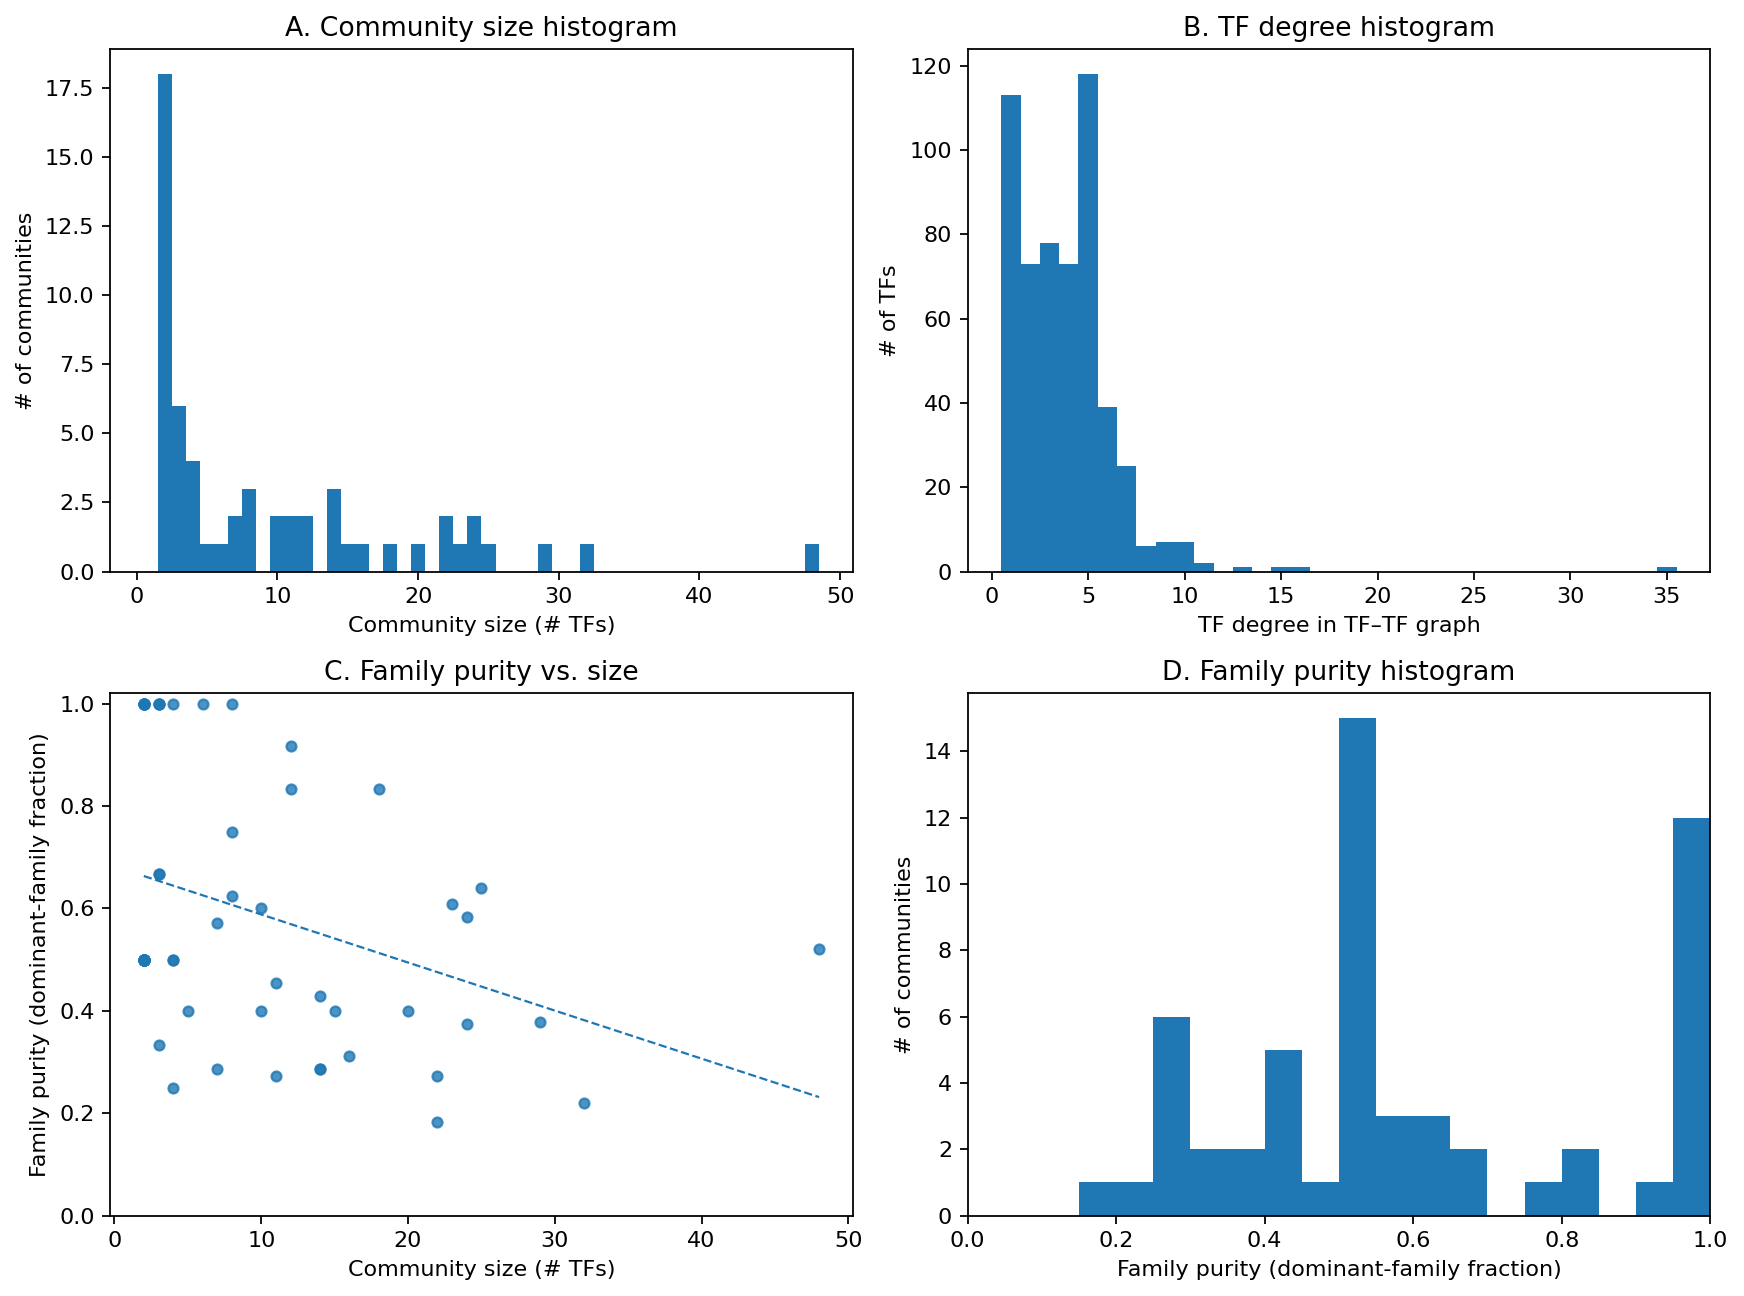

In [19]:

# 1) Prep series for the four panels
sizes   = pd.to_numeric(df_fams["n_TFs"], errors="coerce").dropna()
purity  = pd.to_numeric(df_fams["dom_family_frac"], errors="coerce").clip(0, 1).dropna()

deg = pd.Series(dict(Gbest.degree())).rename("degree")
deg = pd.to_numeric(deg, errors="coerce").dropna()

# 2) Figure: 2×2 overview
fig, axes = plt.subplots(2, 2, figsize=(11, 8.2))

# (A) Community size histogram
ax = axes[0, 0]
ax.hist(sizes, bins=np.arange(1, sizes.max()+2)-0.5)
ax.set_xlabel("Community size (# TFs)")
ax.set_ylabel("# of communities")
ax.set_title("A. Community size histogram")

# (B) TF degree histogram
ax = axes[0, 1]
bins = np.arange(deg.min(), deg.max()+2) - 0.5
ax.hist(deg, bins=bins)
ax.set_xlabel("TF degree in TF–TF graph")
ax.set_ylabel("# of TFs")
ax.set_title("B. TF degree histogram")

# (C) Purity vs size
ax = axes[1, 0]
ax.scatter(sizes, purity, s=20, alpha=0.8)
ax.set_xlabel("Community size (# TFs)")
ax.set_ylabel("Family purity (dominant-family fraction)")
ax.set_ylim(0, 1.02)
ax.set_title("C. Family purity vs. size")
# optional trend line
if len(sizes) >= 3:
    z = np.polyfit(sizes, purity, 1)
    xx = np.linspace(sizes.min(), sizes.max(), 100)
    yy = np.polyval(z, xx)
    ax.plot(xx, yy, linestyle="--", linewidth=1)

# (D) Family purity histogram
ax = axes[1, 1]
ax.hist(purity, bins=np.linspace(0, 1, 21))
ax.set_xlabel("Family purity (dominant-family fraction)")
ax.set_ylabel("# of communities")
ax.set_title("D. Family purity histogram")
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig("overview_panels.png", dpi=200)
print("✓ Saved overview_panels.png")


✓ Saved tf_family_counts.png
✓ Saved tf_family_counts.tsv


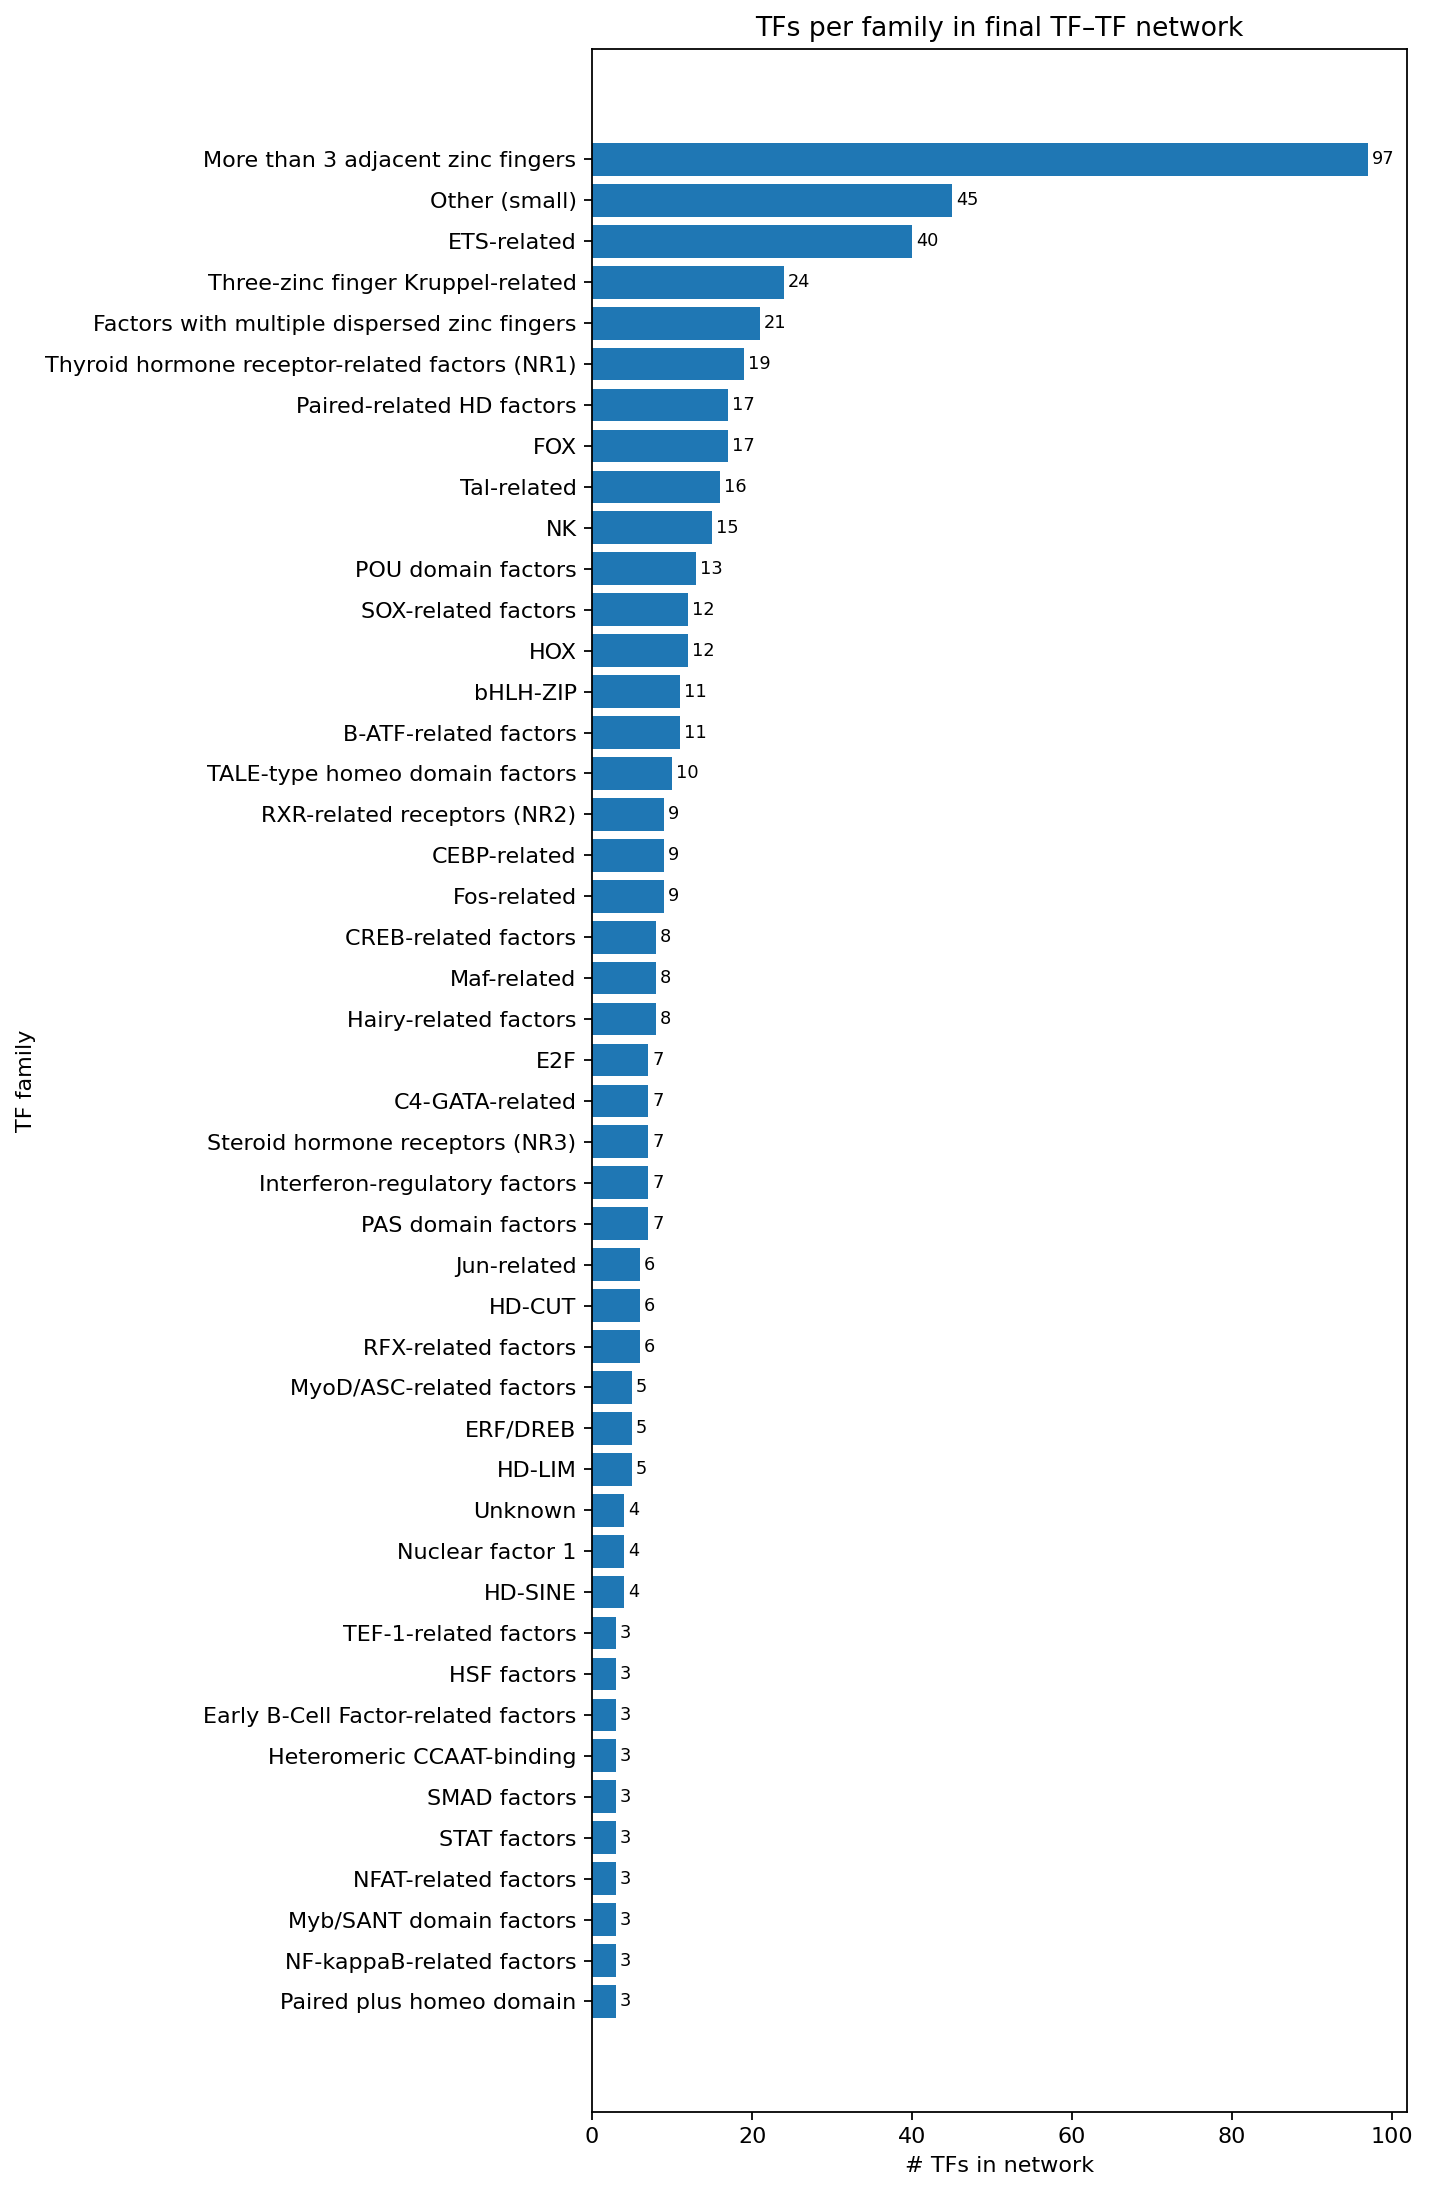

In [21]:


tf_fam = pd.read_csv("tf_families_revised.csv")
tf_fam = tf_fam.rename(columns=lambda c: c.strip().lower())


def _tf_key(x: str) -> str:
    x = str(x).strip().upper()
    x = re.sub(r'(_HUMAN|_MOUSE|_RAT|_VAR\d+)$', '', x)
    x = x.replace(" ", "")
    return x

tf_fam["TF_key"] = tf_fam["tf"].astype(str).map(_tf_key)
tf_fam["family"] = tf_fam["family"].fillna("Unknown").astype(str)


nodes = { _tf_key(t) for t in Gbest.nodes() }


in_net = tf_fam[tf_fam["TF_key"].isin(nodes)].drop_duplicates(subset=["TF_key"])
fam_counts = (in_net.groupby("family", as_index=False)["TF_key"]
                    .nunique()
                    .rename(columns={"TF_key":"n_TFs"})
                    .sort_values("n_TFs", ascending=False))


MIN_PER_FAMILY = 3
big = fam_counts["n_TFs"] >= MIN_PER_FAMILY
other_ct = int(fam_counts.loc[~big, "n_TFs"].sum())
fam_plot = fam_counts.loc[big].copy()

if other_ct > 0:
    fam_plot = pd.concat([fam_plot,
                          pd.DataFrame([{"family":"Other (small)", "n_TFs":other_ct}])],
                         ignore_index=True)
fam_plot = fam_plot.sort_values("n_TFs", ascending=True)


plt.figure(figsize=(9, max(4, 0.3 * len(fam_plot))))
plt.barh(fam_plot["family"], fam_plot["n_TFs"])
for i, (y, n) in enumerate(zip(fam_plot["family"], fam_plot["n_TFs"])):
    plt.text(n + 0.5, i, str(int(n)), va="center", fontsize=8)
plt.xlabel("# TFs in network")
plt.ylabel("TF family")
plt.title("TFs per family in final TF–TF network")
plt.tight_layout()
plt.savefig("tf_family_counts.png", dpi=200)
print("✓ Saved tf_family_counts.png")


fam_counts.to_csv("tf_family_counts.tsv", sep="\t", index=False)
print("✓ Saved tf_family_counts.tsv")


In [ ]:

try:
    TF_LIST = sorted(set(df_edges["TF"]))
except Exception:

    TF_LIST = []

OUT_CSV = "tf_families_revised.csv"
CACHE_JSON = "jaspar_name_cache.json"


def normalize_tf_name(tf_name: str) -> str:
    """Uppercase, strip species/version noise, remove spaces; keep :: intact."""
    tf_name = (tf_name or "").strip().upper()
    tf_name = re.sub(r'(_HUMAN|_MOUSE|_RAT|_VAR\d+)$', '', tf_name)
    tf_name = tf_name.replace(" ", "")
    return tf_name

def split_heterodimer(tf_name: str):
    """Return list of subunits; 'MAX::MYC' -> ['MAX','MYC']."""
    tf_name = normalize_tf_name(tf_name)
    return tf_name.split("::") if "::" in tf_name else [tf_name]

def _tf_key(s: str) -> str:
    """Stable key for dict merging/joins."""
    return normalize_tf_name(s)


FALLBACK_FAMILY_RULES = [
    (r'^(ETS|ELF|ELK|ERG|ETV|FLI)\b',             'ETS-related',              'Winged helix-turn-helix'),
    (r'^(FOXO?|FOX[A-Z0-9]+)\b',                   'FOX',                      'Forkhead'),
    (r'^(HOX|HOXA|HOXB|HOXC|HOXD)\b',              'HOX',                      'Homeobox'),
    (r'^(POU|OCT|POU[0-9A-Z]+)\b',                 'POU',                      'Homeobox'),
    (r'^(GATA)\b',                                 'GATA',                     'Zinc-coordinating'),
    (r'^(KLF|SP[1-9])\b',                          'KLF/SP',                   'Zinc-coordinating'),
    (r'^(NR[0-9A-Z]|RARA|RARB|RARG|RXR|PPAR|ESR|THR|VDR)\b', 'Nuclear Receptor','Nuclear receptor'),
    (r'^(IRF)\b',                                  'IRF',                      'Winged helix-turn-helix'),
    (r'^(SMAD)\b',                                 'SMAD',                     'MH1/SMAD'),
    (r'^(MAF|ATF|CREB|JUN|FOS|CEBP)\b',            'bZIP',                     'Leucine zipper'),
    (r'^(MYC|MAX|MLX|USF)\b',                      'bHLH',                     'Helix-loop-helix'),
    (r'^(TFEB|TFEC|MITF|TFE3)\b',                  'MiT/TFE',                  'bHLH-Zip'),
    (r'^(SOX)\b',                                  'SOX',                      'HMG box'),
    (r'^(RFX)\b',                                  'RFX',                      'Winged helix'),
    (r'^(E2F)\b',                                  'E2F',                      'Winged helix'),
    (r'^(NFY)\b',                                  'NFY',                      'CCAAT-binding'),
    (r'^(CTCF|CTCFL)\b',                           'CTCF',                     'Zinc-coordinating'),
    (r'^(ZNF|ZBTB)\b',                             'C2H2 ZNF',                 'Zinc-coordinating'),
]

def fallback_family_class(one_tf: str):
    """Return (family, class, source) via regex rules or Unknown."""
    name = normalize_tf_name(one_tf)
    for pat, fam, cls in FALLBACK_FAMILY_RULES:
        if re.match(pat, name):
            return fam, cls, 'Fallback'
    return 'Unknown', 'Unknown', 'Fallback'


def _canon(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

FAMILY_SYNONYMS = {

    "ets": "ETS-related",
    "ets-related": "ETS-related",
    "klf/sp": "KLF/SP",
    "znf": "C2H2 ZNF",
    "mit/tfe": "MiT/TFE",
}

CLASS_SYNONYMS = {
    "winged helix turn helix": "Winged helix-turn-helix",
    "winged helix-turn-helix": "Winged helix-turn-helix",
    "winged helix": "Winged helix",
    "hmg-box": "HMG box",
    "hmg box": "HMG box",
    "zinc coordinating": "Zinc-coordinating",
    "helix loop helix": "Helix-loop-helix",
    "bhlh-zip": "bHLH-Zip",
    "mh1/smad": "MH1/SMAD",
    "leucine zipper": "Leucine zipper",
    "nuclear receptor": "Nuclear receptor",
    "ccaat-binding": "CCAAT-binding",
}

def normalize_family_label(lbl: str) -> str:
    key = (lbl or "").strip().lower()
    return _canon(FAMILY_SYNONYMS.get(key, lbl or "Unknown"))

def normalize_class_label(lbl: str) -> str:
    key = (lbl or "").strip().lower()
    return _canon(CLASS_SYNONYMS.get(key, lbl or "Unknown"))


CANON_CLASS_FOR_FAMILY = {
    "ETS-related": "Winged helix-turn-helix",
    "GATA": "Zinc-coordinating",
    "KLF/SP": "Zinc-coordinating",
    "POU": "Homeobox",
    "HOX": "Homeobox",
    "IRF": "Winged helix-turn-helix",
    "RFX": "Winged helix",
    "E2F": "Winged helix",
    "bZIP": "Leucine zipper",
    "bHLH": "Helix-loop-helix",
    "MiT/TFE": "bHLH-Zip",
    "SOX": "HMG box",
    "CTCF": "Zinc-coordinating",
    "C2H2 ZNF": "Zinc-coordinating",
    "SMAD": "MH1/SMAD",
    "Nuclear Receptor": "Nuclear receptor",
    "NFY": "CCAAT-binding",
}


JASPAR_SEARCH = "https://jaspar.elixir.no/api/v1/matrix/?search={q}&format=json"
_session = requests.Session()
_session.headers.update({"User-Agent": "tf-fam-annot/1.0"})


if os.path.exists(CACHE_JSON):
    with open(CACHE_JSON, "r") as fh:
        _DISK_CACHE = json.load(fh)
else:
    _DISK_CACHE = {}

def _cache_get(q):
    return _DISK_CACHE.get(q)

def _cache_put(q, val):
    _DISK_CACHE[q] = val
    try:
        with open(CACHE_JSON, "w") as fh:
            json.dump(_DISK_CACHE, fh)
    except Exception:
        pass

def _best_hit_by_name(hits, query):
    q_up = normalize_tf_name(query)
    for h in hits:
        if normalize_tf_name(h.get("name", "")) == q_up:
            return h
    return hits[0] if hits else None

def _safe_get(url, tries=3, pause=0.5):
    for i in range(tries):
        try:
            r = _session.get(url, timeout=6)
            r.raise_for_status()
            return r.json()
        except Exception:
            if i == tries-1:
                return None
            time.sleep(pause * (1.5**i))
    return None

def jaspar_lookup_one(one_tf: str):
    """
    Return dict: {"tf":..., "family":[...], "class":[...], "source":"JASPAR:1|0|error"}
    """
    q = normalize_tf_name(one_tf)
    hit = _cache_get(q)
    if hit is not None:
        return hit

    try:
        srch = _safe_get(JASPAR_SEARCH.format(q=q))
        hits = (srch or {}).get("results", [])
        if not hits:
            out = {"tf": one_tf, "family": [], "class": [], "source": "JASPAR:0"}
            _cache_put(q, out)
            return out

        best = _best_hit_by_name(hits, q)
        if not best or "url" not in best:
            out = {"tf": one_tf, "family": [], "class": [], "source": "JASPAR:no-url"}
            _cache_put(q, out)
            return out

        detail = _safe_get(best["url"])
        if not detail:
            out = {"tf": one_tf, "family": [], "class": [], "source": "JASPAR:error"}
            _cache_put(q, out)
            return out

        fam = detail.get("family", [])
        cls = detail.get("class", [])
        if isinstance(fam, str): fam = [fam]
        if isinstance(cls, str): cls = [cls]

        # Normalize synonyms immediately
        fam = [normalize_family_label(x) for x in fam if x]
        cls = [normalize_class_label(x) for x in cls if x]

        out = {"tf": one_tf, "family": fam, "class": cls, "source": "JASPAR:1"}
        _cache_put(q, out)
        return out
    except Exception:
        out = {"tf": one_tf, "family": [], "class": [], "source": "JASPAR:error"}
        _cache_put(q, out)
        return out


def _majority_label(labels):
    """Pick one label by frequency; tie-break alphabetically for determinism."""
    labels = [x for x in labels if x and str(x).strip()]
    if not labels:
        return "Unknown"
    vc = pd.Series(labels).value_counts()
    return sorted(vc[vc == vc.max()].index.tolist())[0]

def annotate_one_tf(tf_name: str):
    """
    1) Split heterodimers to subunits
    2) For each subunit, JASPAR first; fallback regex if empty
    3) Majority vote family & class across subunits
    4) Normalize synonyms; then enforce canonical class for the chosen family
    """
    parts = split_heterodimer(tf_name)
    fam_labels, cls_labels, sources = [], [], []

    for p in parts:
        j = jaspar_lookup_one(p)
        if j["family"] or j["class"]:
            fam_labels.extend(j["family"])
            cls_labels.extend(j["class"])
            sources.append(j["source"])
        else:
            fam_f, cls_f, src_f = fallback_family_class(p)
            fam_labels.append(normalize_family_label(fam_f))
            cls_labels.append(normalize_class_label(cls_f))
            sources.append(src_f)

    fam_final = _majority_label([normalize_family_label(x) for x in fam_labels])
    cls_final = _majority_label([normalize_class_label(x) for x in cls_labels])

    # Enforce canonical class for the chosen family (when known)
    canon_cls = CANON_CLASS_FOR_FAMILY.get(fam_final)
    if canon_cls:
        cls_final = canon_cls

    src_note = "+".join(sorted(set(sources))) if sources else "NA"

    return {
        "tf": normalize_tf_name(tf_name),
        "family": fam_final,
        "class": cls_final,
        "source": src_note
    }

def annotate_tfs(tf_iterable):
    """Return DataFrame columns: ['tf','family','class','source']"""
    tf_list = [normalize_tf_name(t) for t in tf_iterable if isinstance(t, str)]
    seen, ordered = set(), []
    for t in tf_list:
        if t and t not in seen:
            ordered.append(t); seen.add(t)
    rows = [annotate_one_tf(t) for t in ordered]
    return pd.DataFrame(rows, columns=["tf","family","class","source"])


if not TF_LIST:
    print("[warn] TF_LIST is empty. Populate TF_LIST (e.g., from df_edges['TF']) and re-run.")
else:
    df_tf_families = annotate_tfs(TF_LIST)
    df_tf_families.to_csv(OUT_CSV, index=False)
    print(f"✓ Wrote {OUT_CSV}  (n={len(df_tf_families)})")


    summ = (
        df_tf_families.assign(source_group=lambda d: d["source"].str.split("+").str[0])
                      .groupby("source_group")["tf"].count()
                      .rename("n_TFs")
                      .reset_index()
                      .sort_values("n_TFs", ascending=False)
    )
    print("\nSource summary:")
    print(summ.to_string(index=False))

    fam_top = df_tf_families["family"].value_counts().head(15)
    cls_top = df_tf_families["class"].value_counts().head(15)
    print("\nTop families:\n", fam_top.to_string())
    print("\nTop classes:\n", cls_top.to_string())


In [24]:
from google.colab import files

dir_to_zip = 'export_20251023_022136'
output_filename = 'export_20251023_022136.zip'


os.system(f"zip -r {output_filename} {dir_to_zip}")


files.download(output_filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>